### Library and Data Processing

To view dashboard visit: https://public.tableau.com/app/profile/leo.li2227/viz/E-commerceSalesDashboard_17231509371580/Overview

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [47]:
data = pd.read_excel('Sales Data.xlsx')
# Get dates for forecast
data['Date'] = data['Year'].astype(str) + '-' + data['Month'].astype(str)
data['Date'] = pd.to_datetime(data['Date'])
# Total revenue by month
df = data.groupby('Date')['Ordered Revenue'].sum().reset_index().rename(columns={'Ordered Revenue':'Monthly Revenue'})

In [52]:
data.sample()

,Year,Month,Subcategory,Category,Model / Style Number,Ordered Revenue,Ordered Revenue - % of Total,Ordered Revenue - Prior Period,Ordered Units,Subcategory (Sales Rank),Glance Views,Change in Glance View - MOM,Change in GV YOY,Conversion Rate,LFO (Price),Date
9742,2021,11,Subcategory 038,Category 13,F3U13306INCH,0.0,0.0,-,0,1040.0,0.0,—,-1,NaN,NaN,2021-11-01


In [53]:
data.groupby(['Date','Category'])['Ordered Revenue'].sum().reset_index().rename(columns={'Ordered Revenue':'Monthly Revenue'})

,Date,Category,Monthly Revenue
0,2021-01-01,Category 01,0.000000e+00
1,2021-01-01,Category 02,5.372027e+03
2,2021-01-01,Category 03,1.014791e+03
3,2021-01-01,Category 05,2.397808e+06
4,2021-01-01,Category 06,3.934972e+01
...,...,...,...
444,2022-06-01,Category 23,2.637233e+05
445,2022-06-01,Category 24,2.176657e+06
446,2022-06-01,Category 25,2.239411e+05
447,2022-06-01,Category 26,1.168172e+03


### SARIMA Forecast

The data shows strong seasonality with peak at November during Black Friday. Holt's Winters could be a great model for this; however, there are only 18 monhts of data which is less than 2 cycles. Therefore, we will use SARIMAX model that considers seasonality to forecast

#### Parameter tuning

In [98]:
# Determine non-seasonal differencing component
from pmdarima.arima.utils import ndiffs
ndiffs(df['Monthly Revenue'])

0

We will set d = 0 in the model

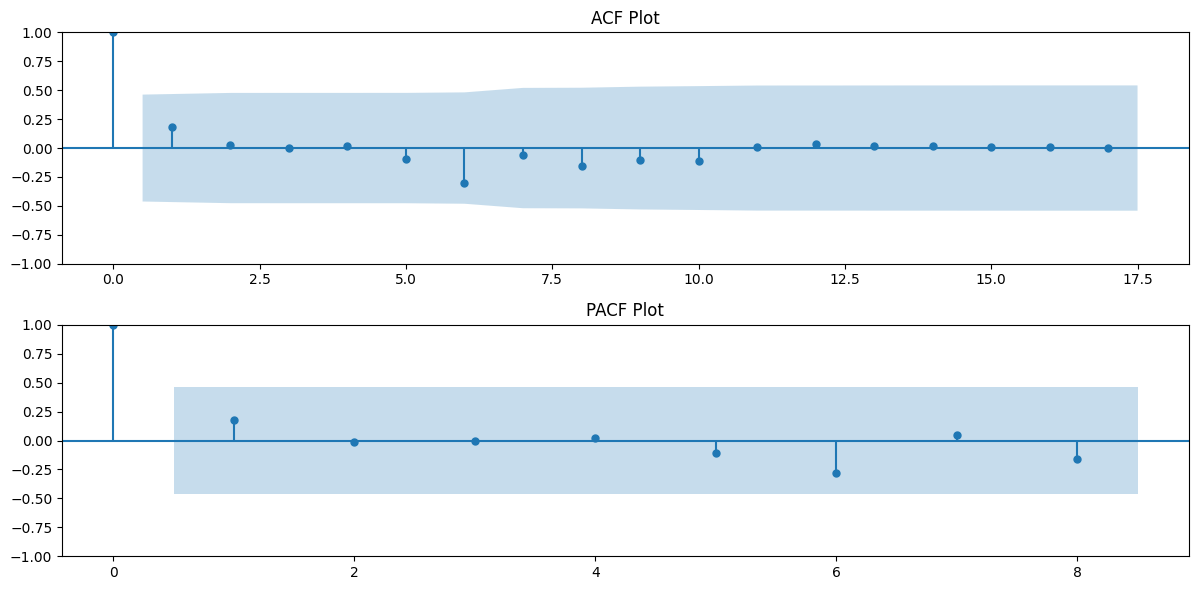

In [88]:
# Plot ACF to help select moving average and PACF to help select autoregressive
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df['Monthly Revenue'], lags=17, ax=plt.gca())
plt.title('ACF Plot')
plt.subplot(212)
plot_pacf(df['Monthly Revenue'], lags=8, ax=plt.gca())
plt.title('PACF Plot')
plt.tight_layout()
plt.show()

No strong indication in ACF and PACF, will use cross validation to select p and q 
Since we only have 1 full period of data so will set P and Q = 1 for seasonal component of the model

In [175]:
# 4 fold cross validation to select p and q
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Prepare TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)
p_values = list(range(9))
q_values = list(range(9))

model_tuning = []
for p in p_values:
    for q in q_values:
        mse_values = []
        for train_index, test_index in tscv.split(df):
            train, test = df.iloc[train_index], df.iloc[test_index]
            try:
                model = SARIMAX(train['Monthly Revenue'], order=(p, 0, q), seasonal_order=(1, 0, 1, 12)).fit()
                forecast = model.forecast(steps=len(test))
                mse_values.append(mean_squared_error(test['Monthly Revenue'], forecast))    
            except Exception as e:
                mse_values.append(np.nan)
        model_tuning.append({'p': p,'q': q,'MSE': np.nanmean(mse_values)})
        
model_tuning = pd.DataFrame(model_tuning)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09219D+02    |proj g|=  9.46740D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4     54      2     0     0   8.654D+02   2.256D+01
  F =   22.559566559791136     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.82349D+01    |proj g|=  5.33529D-04
  ys=-2.394E-02  -gs= 1.801E-03 BFGS update SKIPPED

At iterate    5    f=  1.80633D+01    |proj g|=  4.83013D-02
  ys=-1.918E+01  -gs= 9.503E-01 BFGS update SKIPPED

           * * *

Tit   = t

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.71698D+01    |proj g|=  5.41011D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   3.155D-06   1.717D+01
  F =   17.169755651277033     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71745D+01    |proj g|=  1.69748D-01

At iterate    5    f=  1.71389D+01    |proj g|=  6.44221D-04

At iterate   10    f=  1.71389D+01    |proj g|=  8.14302D-04

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.63518D+01    |proj g|=  1.93496D+00

At iterate   10    f=  2.47617D+01    |proj g|=  1.86234D-01

At iterate   15    f=  1.62985D+01    |proj g|=  1.72070D-01

At iterate   20    f=  1.62870D+01    |proj g|=  1.58031D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     24      1     0     0   8.176D-06   1.629D+01
  F =   16.286955534008467     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11860D+01    |proj g|=  9.33936D+00

At iterate    5    f=  1.67080D+01    |proj g|=  4.71778D-02

At iterate   10    f=  1.66905D+01    |proj g|=  1.77754D-02

At iterate   15    f=  1.66876D+01    |proj g|=  1.81813D-02

At iterate   20    f=  1.66862D+01    |proj g|=  8.57832D-03

At iterate   25    f=  1.66861D+01    |proj g|=  6.59007D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     33      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.68556D+01    |proj g|=  9.20761D-04

At iterate   15    f=  1.68556D+01    |proj g|=  3.70726D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     17      1     0     0   3.707D-06   1.686D+01
  F =   16.855573702312913     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49830D+02    |proj g|=  2.21983D+02

At iterate    5    f=  2.21726D+01    |proj g|=  3.89350D+00

At iter

 This problem is unconstrained.



At iterate   10    f=  1.60276D+01    |proj g|=  7.28130D-02

At iterate   15    f=  1.60027D+01    |proj g|=  1.10979D-02

At iterate   20    f=  1.60027D+01    |proj g|=  3.01398D-03

At iterate   25    f=  1.59805D+01    |proj g|=  8.16627D-03

At iterate   30    f=  1.59805D+01    |proj g|=  8.36258D-04

At iterate   35    f=  1.59804D+01    |proj g|=  9.03068D-03

At iterate   40    f=  1.59800D+01    |proj g|=  2.27724D-02

At iterate   45    f=  1.59797D+01    |proj g|=  1.34826D-02

At iterate   50    f=  1.59790D+01    |proj g|=  7.95630D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     76   

 This problem is unconstrained.



At iterate   25    f=  1.66065D+01    |proj g|=  3.05782D-03

At iterate   30    f=  1.66065D+01    |proj g|=  4.29450D-03

At iterate   35    f=  1.66064D+01    |proj g|=  4.62415D-03

At iterate   40    f=  1.66064D+01    |proj g|=  2.84579D-04

At iterate   45    f=  1.66064D+01    |proj g|=  1.21978D-03

At iterate   50    f=  1.66064D+01    |proj g|=  1.62294D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   1.623D-03   1.661D+01
  F =   16.606356686302309     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.61423D+01    |proj g|=  6.73718D-01

At iterate   25    f=  1.60072D+01    |proj g|=  3.24586D-02

At iterate   30    f=  1.60070D+01    |proj g|=  2.36785D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     30     34      1     0     0   2.368D-05   1.601D+01
  F =   16.006997269405900     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.96079D+01    |proj g|=  1.32868D+02

At iter

 This problem is unconstrained.



At iterate   20    f=  1.59279D+01    |proj g|=  1.42370D-01

At iterate   25    f=  1.58965D+01    |proj g|=  7.15890D-03

At iterate   30    f=  1.58964D+01    |proj g|=  6.02735D-03

At iterate   35    f=  1.58958D+01    |proj g|=  2.74810D-03

At iterate   40    f=  1.58956D+01    |proj g|=  9.06678D-03

At iterate   45    f=  1.58954D+01    |proj g|=  1.03540D-02

At iterate   50    f=  1.58953D+01    |proj g|=  3.90374D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   3.904D-03   1.590D+01
  F =   15.895289831353530     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.


 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33001D+01    |proj g|=  1.32308D+01

At iterate    5    f=  1.67439D+01    |proj g|=  4.61624D-01

At iterate   10    f=  1.65431D+01    |proj g|=  2.57339D-02

At iterate   15    f=  1.65357D+01    |proj g|=  1.39913D-01

At iterate   20    f=  1.65241D+01    |proj g|=  2.11207D-02

At iterate   25    f=  1.65215D+01    |proj g|=  2.81804D-02

At iterate   30    f=  1.65201D+01    |proj g|=  1.04501D-02

At iterate   35    f=  1.65195D+01    |proj g|=  6.09836D-03

At iterate   40    f=  1.65194D+01    |proj g|=  4.94258D-04

At iterate   45    f=  1.65193D+01    |proj g|=  1.68558D-03

At iterate   50    f=  1.65193D+01    |proj g|=  2.08369D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of activ

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.63733D+01    |proj g|=  1.48852D-02

At iterate   20    f=  1.63726D+01    |proj g|=  4.06307D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     22     24      1     0     0   7.502D-06   1.637D+01
  F =   16.372591804370696     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76931D+02    |proj g|=  2.66379D+02

At iterate    5    f=  2.10093D+01    |proj g|=  5.97653D+00

At iter

 This problem is unconstrained.



At iterate   30    f=  1.56376D+01    |proj g|=  9.81520D-04

At iterate   35    f=  1.56374D+01    |proj g|=  9.80775D-03

At iterate   40    f=  1.56373D+01    |proj g|=  1.02857D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     47      1     0     0   5.565D-05   1.564D+01
  F =   15.637306704198396     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37292D+01    |proj g|=  1.40090D+01

At iter

 This problem is unconstrained.



At iterate   10    f=  1.64978D+01    |proj g|=  2.63007D-02

At iterate   15    f=  1.64943D+01    |proj g|=  2.05616D-02

At iterate   20    f=  1.64936D+01    |proj g|=  4.87772D-03

At iterate   25    f=  1.64933D+01    |proj g|=  1.66532D-03

At iterate   30    f=  1.64933D+01    |proj g|=  2.16607D-03

At iterate   35    f=  1.64933D+01    |proj g|=  6.21819D-04

At iterate   40    f=  1.64933D+01    |proj g|=  1.68466D-04

At iterate   45    f=  1.64933D+01    |proj g|=  1.73030D-03

At iterate   50    f=  1.64933D+01    |proj g|=  6.39414D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57   

 This problem is unconstrained.



At iterate   20    f=  1.63490D+01    |proj g|=  3.46651D-03

At iterate   25    f=  1.63489D+01    |proj g|=  1.59431D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     26     28      1     0     0   1.652D-04   1.635D+01
  F =   16.348913293293613     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90487D+02    |proj g|=  2.88577D+02


 This problem is unconstrained.



At iterate    5    f=  1.77524D+01    |proj g|=  1.73179D+00

At iterate   10    f=  1.57851D+01    |proj g|=  1.91816D-01

At iterate   15    f=  1.56911D+01    |proj g|=  2.39550D-02

At iterate   20    f=  1.56891D+01    |proj g|=  1.28747D-02

At iterate   25    f=  1.56824D+01    |proj g|=  1.82738D-02

At iterate   30    f=  1.56808D+01    |proj g|=  1.87251D-02

At iterate   35    f=  1.56806D+01    |proj g|=  7.61610D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     37     42      1     0     0   1.202D-04   1.568D+01
  F =   15.680625351877973     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  1.57577D+01    |proj g|=  5.76909D-01

At iterate   20    f=  1.56140D+01    |proj g|=  2.77735D-02

At iterate   25    f=  1.56040D+01    |proj g|=  2.51891D-02

At iterate   30    f=  1.56034D+01    |proj g|=  1.80702D-03

At iterate   35    f=  1.56031D+01    |proj g|=  1.48820D-02

At iterate   40    f=  1.56030D+01    |proj g|=  9.53292D-04

At iterate   45    f=  1.56030D+01    |proj g|=  7.97626D-03

At iterate   50    f=  1.56029D+01    |proj g|=  8.83647D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     58      1     0     0   8.836D-03   1.560D+01
  F =   15.6028906731

 This problem is unconstrained.



At iterate   25    f=  1.64426D+01    |proj g|=  3.66950D-03

At iterate   30    f=  1.64425D+01    |proj g|=  2.02058D-03

At iterate   35    f=  1.64424D+01    |proj g|=  8.93352D-04

At iterate   40    f=  1.64424D+01    |proj g|=  2.20969D-03

At iterate   45    f=  1.64424D+01    |proj g|=  3.11238D-03

At iterate   50    f=  1.64424D+01    |proj g|=  1.93554D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     55      1     0     0   1.936D-03   1.644D+01
  F =   16.442374869221052     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.63870D+01    |proj g|=  2.91991D-01

At iterate   10    f=  1.63197D+01    |proj g|=  2.02571D-02

At iterate   15    f=  1.63155D+01    |proj g|=  1.02601D-02

At iterate   20    f=  1.63148D+01    |proj g|=  1.43825D-02

At iterate   25    f=  1.63146D+01    |proj g|=  1.06838D-04

At iterate   30    f=  1.63146D+01    |proj g|=  1.19058D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     31     35      1     0     0   6.079D-05   1.631D+01
  F =   16.314582192786350     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f=  1.56935D+01    |proj g|=  1.16019D-01

At iterate   25    f=  1.56595D+01    |proj g|=  3.04824D-02

At iterate   30    f=  1.56583D+01    |proj g|=  3.17353D-02

At iterate   35    f=  1.56549D+01    |proj g|=  2.16599D-02

At iterate   40    f=  1.56541D+01    |proj g|=  5.77089D-03

At iterate   45    f=  1.56540D+01    |proj g|=  1.16898D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     46     58      1     0     0   1.726D-04   1.565D+01
  F =   15.653966979062533     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  1.55543D+01    |proj g|=  6.94828D-02

At iterate   20    f=  1.55500D+01    |proj g|=  4.81209D-02

At iterate   25    f=  1.55429D+01    |proj g|=  1.55722D-02

At iterate   30    f=  1.55426D+01    |proj g|=  1.12457D-02

At iterate   35    f=  1.55373D+01    |proj g|=  4.15319D-02

At iterate   40    f=  1.55295D+01    |proj g|=  2.25553D-02

At iterate   45    f=  1.55265D+01    |proj g|=  1.92090D-02

At iterate   50    f=  1.55255D+01    |proj g|=  2.32815D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   2.328D-02   1.553D+01
  F =   15.5254646813

 This problem is unconstrained.



At iterate   25    f=  1.64293D+01    |proj g|=  3.70191D-02

At iterate   30    f=  1.64252D+01    |proj g|=  1.39384D-02

At iterate   35    f=  1.64249D+01    |proj g|=  2.03715D-03

At iterate   40    f=  1.64248D+01    |proj g|=  2.92487D-04

At iterate   45    f=  1.64248D+01    |proj g|=  2.72628D-03

At iterate   50    f=  1.64248D+01    |proj g|=  6.09003D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   6.090D-04   1.642D+01
  F =   16.424779194330956     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   25    f=  1.62989D+01    |proj g|=  2.51293D-04

At iterate   30    f=  1.62989D+01    |proj g|=  3.96060D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     31     34      1     0     0   8.276D-06   1.630D+01
  F =   16.298871579420695     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56441D+01    |proj g|=  2.36519D-02

At iterate    5    f=  1.56426D+01    |proj g|=  1.69788D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.55199D+01    |proj g|=  2.09508D-03

At iterate   20    f=  1.55159D+01    |proj g|=  7.53311D-03

At iterate   25    f=  1.55152D+01    |proj g|=  9.35669D-04

At iterate   30    f=  1.55138D+01    |proj g|=  3.53746D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     57      1     0     0   8.873D-07   1.551D+01
  F =   15.513801955377277     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.01067D+02    |proj g|=  9.59916D+02

At iterate    5    f=  1.57823D+01    |proj g|=  1.09576D+00

At iterate   10    f=  1.53589D+01    |proj g|=  8.94446D-02

At iterate   15    f=  1.53483D+01    |proj g|=  5.21111D-02

At iterate   20    f=  1.52975D+01    |proj g|=  3.50092D-02

At iterate   25    f=  1.52790D+01    |proj g|=  2.00181D-02

At iterate   30    f=  1.52732D+01    |proj g|=  4.85427D-03

At iterate   35    f=  1.52719D+01    |proj g|=  2.96800D-03

At iterate   40    f=  1.52716D+01    |proj g|=  8.03434D-03

At iterate   45    f=  1.52715D+01    |proj g|=  3.47879D-03

At iterate   50    f=  1.52715D+01    |proj g|=  1.39242D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  1.53650D+01    |proj g|=  4.18459D-04

At iterate   35    f=  1.53650D+01    |proj g|=  2.51192D-03

At iterate   40    f=  1.53649D+01    |proj g|=  2.84418D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     48      1     0     0   2.046D-05   1.536D+01
  F =   15.364937145384324     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15577D+01    |proj g|=  1.00326D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  1.63673D+01    |proj g|=  6.73275D-04

At iterate   45    f=  1.63673D+01    |proj g|=  3.06407D-04

At iterate   50    f=  1.63673D+01    |proj g|=  8.30578D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57      1     0     0   8.306D-04   1.637D+01
  F =   16.367276020466413     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08701D+01    |proj g|=  3.22782D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.50505D+01    |proj g|=  1.28901D-02

At iterate   25    f=  1.50449D+01    |proj g|=  6.47550D-03

At iterate   30    f=  1.50445D+01    |proj g|=  7.94885D-04

At iterate   35    f=  1.50445D+01    |proj g|=  8.47935D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     41      1     0     0   8.479D-05   1.504D+01
  F =   15.044465331929317     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  1.68981D+01    |proj g|=  9.50340D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     51      1     0     0   4.048D-04   1.690D+01
  F =   16.898094100241398     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.08182D+01    |proj g|=  7.38548D+01

At iterate    5    f=  1.77349D+01    |proj g|=  6.15896D-01

At iterate   10    f=  1.72220D+01    |proj g|=  4.60759D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  1.49973D+01    |proj g|=  1.43357D-02

At iterate   30    f=  1.49939D+01    |proj g|=  1.97648D-03

At iterate   35    f=  1.49935D+01    |proj g|=  6.70222D-04

At iterate   40    f=  1.49934D+01    |proj g|=  5.12632D-03

At iterate   45    f=  1.49933D+01    |proj g|=  3.60251D-03
  ys=-1.056E-06  -gs= 1.643E-05 BFGS update SKIPPED

At iterate   50    f=  1.49933D+01    |proj g|=  5.28707D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69      1     1     0   5.287D-04   1.499D+01
  F =   14.993330670782976     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

 This problem is unconstrained.



At iterate   20    f=  1.53597D+01    |proj g|=  7.65068D-02

At iterate   25    f=  1.53426D+01    |proj g|=  1.25472D-02

At iterate   30    f=  1.53408D+01    |proj g|=  6.02282D-03

At iterate   35    f=  1.53406D+01    |proj g|=  3.81350D-03

At iterate   40    f=  1.53405D+01    |proj g|=  1.71852D-03

At iterate   45    f=  1.53405D+01    |proj g|=  1.95217D-03

At iterate   50    f=  1.53404D+01    |proj g|=  4.74552D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   4.746D-04   1.534D+01
  F =   15.340445090033350     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   20    f=  1.63124D+01    |proj g|=  8.47022D-04

At iterate   25    f=  1.63124D+01    |proj g|=  5.47169D-04

At iterate   30    f=  1.63123D+01    |proj g|=  3.55272D-03

At iterate   35    f=  1.63123D+01    |proj g|=  1.40380D-03

At iterate   40    f=  1.63123D+01    |proj g|=  1.45050D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     47      1     0     0   1.451D-05   1.631D+01
  F =   16.312251681479804     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.62595D+01    |proj g|=  9.84462D-03

At iterate   25    f=  1.62587D+01    |proj g|=  7.05972D-03

At iterate   30    f=  1.62557D+01    |proj g|=  2.75271D-03

At iterate   35    f=  1.62556D+01    |proj g|=  1.24846D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     42      1     0     0   5.816D-05   1.626D+01
  F =   16.255567873103921     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28728D+01    |proj g|=  1.24527D+01

At iterate    5    f=  1.65865D+01    |proj g|=  4.68446D-01

At iterate   10    f=  1.63740D+01    |proj g|=  2.85407D-01

At iterate   15    f=  1.63058D+01    |proj g|=  1.52617D-01

At iterate   20    f=  1.62739D+01    |proj g|=  6.75888D-03

At iterate   25    f=  1.62730D+01    |proj g|=  3.94024D-03

At iterate   30    f=  1.62722D+01    |proj g|=  2.85943D-03

At iterate   35    f=  1.62711D+01    |proj g|=  1.37537D-02

At iterate   40    f=  1.62705D+01    |proj g|=  3.49264D-03

At iterate   45    f=  1.62705D+01    |proj g|=  1.07729D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  1.62825D+01    |proj g|=  2.60942D-02

At iterate   10    f=  1.62662D+01    |proj g|=  2.27869D-02

At iterate   15    f=  1.62565D+01    |proj g|=  1.66532D-02

At iterate   20    f=  1.62544D+01    |proj g|=  3.59815D-03

At iterate   25    f=  1.62514D+01    |proj g|=  2.88377D-02

At iterate   30    f=  1.62472D+01    |proj g|=  2.36103D-02

At iterate   35    f=  1.62457D+01    |proj g|=  4.60315D-03

At iterate   40    f=  1.62456D+01    |proj g|=  9.01522D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     50      1     0     0   4.990D-05   1.625D+01
  F =   16.2455975896

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63378D+02    |proj g|=  2.44185D+02

At iterate    5    f=  1.58802D+01    |proj g|=  1.14365D+00

At iterate   10    f=  1.53173D+01    |proj g|=  1.07998D-01

At iterate   15    f=  1.50908D+01    |proj g|=  2.27881D-01

At iterate   20    f=  1.50044D+01    |proj g|=  6.54000D-02

At iterate   25    f=  1.49502D+01    |proj g|=  2.58536D-02

At iterate   30    f=  1.49473D+01    |proj g|=  6.42938D-03

At iterate   35    f=  1.49415D+01    |proj g|=  1.11110D-01

At iterate   40    f=  1.49304D+01    |proj g|=  2.66787D-02

At iterate   45    f=  1.49242D+01    |proj g|=  2.72772D-03

At iterate   50    f=  1.49242D+01    |proj g|=  8.80780D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   30    f=  1.54090D+01    |proj g|=  7.27975D-04

At iterate   35    f=  1.54090D+01    |proj g|=  2.92958D-03

At iterate   40    f=  1.54088D+01    |proj g|=  3.20415D-03

At iterate   45    f=  1.54085D+01    |proj g|=  1.30586D-02

At iterate   50    f=  1.54044D+01    |proj g|=  7.49680D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     66      1     0     0   7.497D-02   1.540D+01
  F =   15.404436393140575     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

 This problem is unconstrained.


At iterate   30    f=  1.62660D+01    |proj g|=  3.31921D-03

At iterate   35    f=  1.62654D+01    |proj g|=  4.21259D-03

At iterate   40    f=  1.62653D+01    |proj g|=  1.68413D-03

At iterate   45    f=  1.62653D+01    |proj g|=  9.81103D-05

At iterate   50    f=  1.62653D+01    |proj g|=  8.96143D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57      1     0     0   8.961D-04   1.627D+01
  F =   16.265255631842880     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10


 This problem is unconstrained.



At iterate   15    f=  1.62513D+01    |proj g|=  2.85522D-02

At iterate   20    f=  1.62329D+01    |proj g|=  4.49258D-02

At iterate   25    f=  1.62282D+01    |proj g|=  1.99807D-02

At iterate   30    f=  1.62268D+01    |proj g|=  7.71923D-03

At iterate   35    f=  1.62195D+01    |proj g|=  1.05837D-02

At iterate   40    f=  1.62163D+01    |proj g|=  1.27300D-02

At iterate   45    f=  1.62152D+01    |proj g|=  3.89119D-03

At iterate   50    f=  1.62150D+01    |proj g|=  4.32589D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   4.326D-04   1.621D+01
  F =   16.2149979343

 This problem is unconstrained.



At iterate   10    f=  1.52779D+01    |proj g|=  1.12336D-01

At iterate   15    f=  1.50551D+01    |proj g|=  1.94440D-01

At iterate   20    f=  1.49546D+01    |proj g|=  2.48122D-02

At iterate   25    f=  1.49297D+01    |proj g|=  3.31563D-02

At iterate   30    f=  1.49235D+01    |proj g|=  2.33979D-02

At iterate   35    f=  1.49231D+01    |proj g|=  2.35152D-03

At iterate   40    f=  1.49231D+01    |proj g|=  4.49138D-03

At iterate   45    f=  1.49229D+01    |proj g|=  4.23471D-03

At iterate   50    f=  1.49228D+01    |proj g|=  1.08951D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     58   

 This problem is unconstrained.



At iterate    5    f=  1.61784D+01    |proj g|=  6.25751D-01

At iterate   10    f=  1.55453D+01    |proj g|=  9.51969D-02

At iterate   15    f=  1.54848D+01    |proj g|=  4.48011D-02

At iterate   20    f=  1.54143D+01    |proj g|=  6.58167D-02

At iterate   25    f=  1.53022D+01    |proj g|=  1.67213D-01

At iterate   30    f=  1.52618D+01    |proj g|=  4.48162D-02

At iterate   35    f=  1.52560D+01    |proj g|=  1.02521D-02

At iterate   40    f=  1.52554D+01    |proj g|=  8.49256D-03

At iterate   45    f=  1.52550D+01    |proj g|=  5.73978D-04

At iterate   50    f=  1.52549D+01    |proj g|=  4.12112D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.64257D+01    |proj g|=  1.80893D-01

At iterate   15    f=  1.62990D+01    |proj g|=  6.72974D-02

At iterate   20    f=  1.62669D+01    |proj g|=  1.03523D-02

At iterate   25    f=  1.62609D+01    |proj g|=  4.94096D-02

At iterate   30    f=  1.62594D+01    |proj g|=  7.25300D-03

At iterate   35    f=  1.62592D+01    |proj g|=  1.55584D-03

At iterate   40    f=  1.62590D+01    |proj g|=  1.69849D-03

At iterate   45    f=  1.62590D+01    |proj g|=  6.87274D-04

At iterate   50    f=  1.62590D+01    |proj g|=  8.33798D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57   

 This problem is unconstrained.



At iterate   10    f=  1.62896D+01    |proj g|=  2.57948D-01

At iterate   15    f=  1.62233D+01    |proj g|=  3.79431D-02

At iterate   20    f=  1.62101D+01    |proj g|=  1.75716D-02

At iterate   25    f=  1.62089D+01    |proj g|=  1.12345D-02

At iterate   30    f=  1.62067D+01    |proj g|=  3.85472D-02

At iterate   35    f=  1.62002D+01    |proj g|=  1.13818D-02

At iterate   40    f=  1.61985D+01    |proj g|=  4.92731D-03

At iterate   45    f=  1.61971D+01    |proj g|=  3.74031D-03

At iterate   50    f=  1.61966D+01    |proj g|=  2.53608D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     55   

 This problem is unconstrained.



At iterate   35    f=  1.49002D+01    |proj g|=  1.04405D-02

At iterate   40    f=  1.48997D+01    |proj g|=  7.35313D-03

At iterate   45    f=  1.48996D+01    |proj g|=  1.55469D-03

At iterate   50    f=  1.48995D+01    |proj g|=  6.49691D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     55      1     0     0   6.497D-04   1.490D+01
  F =   14.899473594938286     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  1.53102D+01    |proj g|=  1.45894D-01

At iterate   20    f=  1.52726D+01    |proj g|=  5.55399D-02

At iterate   25    f=  1.52586D+01    |proj g|=  1.00178D-01

At iterate   30    f=  1.52450D+01    |proj g|=  1.10210D-01

At iterate   35    f=  1.52413D+01    |proj g|=  8.28210D-03

At iterate   40    f=  1.52391D+01    |proj g|=  2.85259D-02

At iterate   45    f=  1.52385D+01    |proj g|=  1.45797D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   50    f=  1.52385D+01    |proj g|=  1.23939D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     82      2     0     0   1.239D-03   1.524D+01
  F =   15.238506560650841     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41599D+01    |proj g|=  1.47876D+01

At iterate    5    f=  1.66778D+01    |proj g|=  3.52725D-01

At iterate   10    f=  1.63988D+01    |proj g|=  2.42817D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  1.62691D+01    |proj g|=  1.20142D-01

At iterate   15    f=  1.62450D+01    |proj g|=  8.83827D-02

At iterate   20    f=  1.62262D+01    |proj g|=  6.09565D-02

At iterate   25    f=  1.62103D+01    |proj g|=  2.27690D-02

At iterate   30    f=  1.62055D+01    |proj g|=  8.78138D-03

At iterate   35    f=  1.62046D+01    |proj g|=  6.82288D-03

At iterate   40    f=  1.61999D+01    |proj g|=  1.06361D-02

At iterate   45    f=  1.61953D+01    |proj g|=  1.52147D-02

At iterate   50    f=  1.61930D+01    |proj g|=  9.11392D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     55   

 This problem is unconstrained.



At iterate    5    f=  1.59628D+01    |proj g|=  1.06384D+00

At iterate   10    f=  1.52140D+01    |proj g|=  1.07900D-01

At iterate   15    f=  1.50799D+01    |proj g|=  3.45747D-01

At iterate   20    f=  1.49906D+01    |proj g|=  7.79534D-02

At iterate   25    f=  1.49303D+01    |proj g|=  2.53087D-02

At iterate   30    f=  1.49082D+01    |proj g|=  9.81060D-02

At iterate   35    f=  1.48954D+01    |proj g|=  1.60301D-02

At iterate   40    f=  1.48922D+01    |proj g|=  1.50506D-02

At iterate   45    f=  1.48900D+01    |proj g|=  4.12792D-03

At iterate   50    f=  1.48887D+01    |proj g|=  4.77720D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  1.52529D+01    |proj g|=  1.02835D-01

At iterate   25    f=  1.52258D+01    |proj g|=  1.65286D-02

At iterate   30    f=  1.52160D+01    |proj g|=  2.01399D-02

At iterate   35    f=  1.52132D+01    |proj g|=  8.28034D-03

At iterate   40    f=  1.52117D+01    |proj g|=  3.82790D-03

At iterate   45    f=  1.52116D+01    |proj g|=  5.99987D-03

At iterate   50    f=  1.52115D+01    |proj g|=  2.84802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   2.848D-03   1.521D+01
  F =   15.211464943538225     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   25    f=  1.62805D+01    |proj g|=  5.29546D-02

At iterate   30    f=  1.62773D+01    |proj g|=  1.33930D-02

At iterate   35    f=  1.62760D+01    |proj g|=  7.51739D-03

At iterate   40    f=  1.62757D+01    |proj g|=  4.45291D-03

At iterate   45    f=  1.62752D+01    |proj g|=  4.82152D-03

At iterate   50    f=  1.62750D+01    |proj g|=  2.37122D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     57      1     0     0   2.371D-03   1.628D+01
  F =   16.275032259804554     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.63113D+01    |proj g|=  1.28874D-01

At iterate   10    f=  1.62765D+01    |proj g|=  1.55405D-01

At iterate   15    f=  1.62381D+01    |proj g|=  8.40090D-02

At iterate   20    f=  1.62203D+01    |proj g|=  4.70648D-02

At iterate   25    f=  1.62036D+01    |proj g|=  2.07058D-02

At iterate   30    f=  1.62017D+01    |proj g|=  5.40219D-03

At iterate   35    f=  1.62001D+01    |proj g|=  4.45274D-03

At iterate   40    f=  1.61980D+01    |proj g|=  1.31983D-02

At iterate   45    f=  1.61928D+01    |proj g|=  2.51803D-02

At iterate   50    f=  1.61899D+01    |proj g|=  2.13257D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  1.51769D+01    |proj g|=  3.74071D-03

At iterate   35    f=  1.51768D+01    |proj g|=  1.37703D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     45      1     0     0   1.377D-05   1.518D+01
  F =   15.176826500733867     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.49211D+01    |proj g|=  5.33126D+01

At iterate    5    f=  1.55488D+01    |proj g|=  1.90951D-01

At iter

 This problem is unconstrained.



At iterate   25    f=  1.63903D+01    |proj g|=  2.07544D-03

At iterate   30    f=  1.63903D+01    |proj g|=  1.01199D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     38      1     0     0   9.800D-06   1.639D+01
  F =   16.390272060847490     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63456D+01    |proj g|=  3.40979D-02

At iterate    5    f=  1.63405D+01    |proj g|=  4.37532D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.83689D+15    |proj g|=  1.38356D+17

At iterate   15    f=  6.12669D+14    |proj g|=  6.56290D+15

At iterate   20    f=  5.57757D+13    |proj g|=  2.44666D+14

At iterate   25    f=  3.17695D+12    |proj g|=  7.46695D+12

At iterate   30    f=  1.03413D+11    |proj g|=  1.61240D+11

At iterate   35    f=  5.95719D+09    |proj g|=  6.44047D+09

At iterate   40    f=  4.02219D+08    |proj g|=  2.74384D+08

At iterate   45    f=  2.89021D+07    |proj g|=  1.12726D+07

At iterate   50    f=  2.12639D+06    |proj g|=  4.61736D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68   

 This problem is unconstrained.



At iterate   20    f=  1.53873D+01    |proj g|=  4.22668D-03

At iterate   25    f=  1.53864D+01    |proj g|=  6.76971D-04

At iterate   30    f=  1.53864D+01    |proj g|=  7.69921D-04

At iterate   35    f=  1.53862D+01    |proj g|=  2.66942D-03

At iterate   40    f=  1.53861D+01    |proj g|=  2.12086D-03

At iterate   45    f=  1.53860D+01    |proj g|=  2.48709D-04

At iterate   50    f=  1.53860D+01    |proj g|=  3.82645D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   3.826D-05   1.539D+01
  F =   15.386016486241589     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  1.64240D+01    |proj g|=  1.52439D-01

At iterate   10    f=  1.63673D+01    |proj g|=  2.84907D-02

At iterate   15    f=  1.63594D+01    |proj g|=  9.41932D-03

At iterate   20    f=  1.63580D+01    |proj g|=  2.38423D-03

At iterate   25    f=  1.63579D+01    |proj g|=  1.35706D-04

At iterate   30    f=  1.63579D+01    |proj g|=  3.34200D-03

At iterate   35    f=  1.63579D+01    |proj g|=  9.76245D-04

At iterate   40    f=  1.63579D+01    |proj g|=  5.88675D-04

At iterate   45    f=  1.63578D+01    |proj g|=  1.66756D-04

At iterate   50    f=  1.63578D+01    |proj g|=  2.92178D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.64228D+01    |proj g|=  2.64155D-01

At iterate   10    f=  1.63500D+01    |proj g|=  3.60654D-02

At iterate   15    f=  1.63058D+01    |proj g|=  1.91161D-02

At iterate   20    f=  1.62942D+01    |proj g|=  2.97058D-03

At iterate   25    f=  1.62939D+01    |proj g|=  2.56216D-04

At iterate   30    f=  1.62939D+01    |proj g|=  8.08988D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     31      1     0     0   8.090D-06   1.629D+01
  F =   16.293853707665626     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  3.55267D+13    |proj g|=  3.97322D+14

At iterate   20    f=  3.74582D+12    |proj g|=  1.67506D+13

At iterate   25    f=  2.45212D+11    |proj g|=  5.09388D+11

At iterate   30    f=  1.42891D+10    |proj g|=  1.83225D+10

At iterate   35    f=  1.04972D+09    |proj g|=  7.98896D+08

At iterate   40    f=  8.05509D+07    |proj g|=  3.39376D+07

At iterate   45    f=  4.78932D+06    |proj g|=  1.01851D+06

At iterate   50    f=  3.47478D+05    |proj g|=  3.01612D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69      1     0     0   3.016D+05   3.475D+05
  F =   347478.115776

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.64938D+01    |proj g|=  1.71617D-01

At iterate   10    f=  1.64042D+01    |proj g|=  3.51308D-02

At iterate   15    f=  1.63964D+01    |proj g|=  4.12621D-03

At iterate   20    f=  1.63944D+01    |proj g|=  9.28620D-03

At iterate   25    f=  1.63941D+01    |proj g|=  1.86483D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     29      1     0     0   5.936D-05   1.639D+01
  F =   16.394057609691860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate   35    f=  1.49791D+01    |proj g|=  6.37892D-02

At iterate   40    f=  1.49672D+01    |proj g|=  2.04467D-02

At iterate   45    f=  1.49623D+01    |proj g|=  1.00990D-02

At iterate   50    f=  1.49622D+01    |proj g|=  3.51604D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     95      2     0     0   3.516D-03   1.496D+01
  F =   14.962152432149873     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   15    f=  1.52558D+01    |proj g|=  2.68837D-02

At iterate   20    f=  1.52340D+01    |proj g|=  6.76554D-03

At iterate   25    f=  1.52319D+01    |proj g|=  4.01936D-03

At iterate   30    f=  1.52318D+01    |proj g|=  7.08640D-04

At iterate   35    f=  1.52318D+01    |proj g|=  6.82003D-04

At iterate   40    f=  1.52317D+01    |proj g|=  4.40346D-03

At iterate   45    f=  1.52317D+01    |proj g|=  3.13537D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     52      1     0     0   1.205D-05   1.523D+01
  F =   15.231716323581594     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  1.63024D+01    |proj g|=  1.78588D-02

At iterate   15    f=  1.62948D+01    |proj g|=  4.78255D-03

At iterate   20    f=  1.62936D+01    |proj g|=  1.06255D-02

At iterate   25    f=  1.62933D+01    |proj g|=  2.91299D-04

At iterate   30    f=  1.62933D+01    |proj g|=  4.79265D-04

At iterate   35    f=  1.62932D+01    |proj g|=  1.11013D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     43      1     0     0   9.623D-05   1.629D+01
  F =   16.293200890971303     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  1.61910D+01    |proj g|=  3.19150D-02

At iterate   20    f=  1.61887D+01    |proj g|=  2.29918D-03

At iterate   25    f=  1.61868D+01    |proj g|=  3.84131D-03

At iterate   30    f=  1.61856D+01    |proj g|=  6.36893D-03

At iterate   35    f=  1.61848D+01    |proj g|=  3.69935D-03

At iterate   40    f=  1.61845D+01    |proj g|=  3.39413D-03

At iterate   45    f=  1.61843D+01    |proj g|=  1.03713D-03

At iterate   50    f=  1.61843D+01    |proj g|=  4.89788D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   4.898D-05   1.618D+01
  F =   16.1842577832

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     49      1     0     0   5.162D-04   1.495D+01
  F =   14.946828078348114     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42597D+01    |proj g|=  1.23380D+02

At iterate    5    f=  1.52951D+01    |proj g|=  1.59324D-01

At iterate   10    f=  1.52651D+01    |proj g|=  1.26421D-01

At iterate   15    f=  1.52513D+01    |proj g|=  3.39074D-02

At iter

 This problem is unconstrained.



At iterate   50    f=  1.52256D+01    |proj g|=  2.74286D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     55      1     0     0   2.743D-04   1.523D+01
  F =   15.225640309801662     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28728D+01    |proj g|=  1.24527D+01

At iterate    5    f=  1.63998D+01    |proj g|=  1.39775D-01

At iterate   10    f=  1.62895D+01    |proj g|=  3.32642D-02

At iter

 This problem is unconstrained.



At iterate   50    f=  1.62687D+01    |proj g|=  1.13331D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     59      1     0     0   1.133D-02   1.627D+01
  F =   16.268659680048152     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65243D+01    |proj g|=  6.30218D-01

At iterate    5    f=  1.62954D+01    |proj g|=  1.19731D-01

At iterate   10    f=  1.62724D+01    |proj g|=  1.73993D-02

At iter

 This problem is unconstrained.



At iterate   45    f=  1.62359D+01    |proj g|=  1.92683D-03

At iterate   50    f=  1.62359D+01    |proj g|=  4.43237D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     55      1     0     0   4.432D-05   1.624D+01
  F =   16.235887132584438     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63378D+02    |proj g|=  2.44185D+02

At iterate    5    f=  1.53063D+01    |proj g|=  6.64530D-01

At iter

 This problem is unconstrained.



At iterate   40    f=  1.49185D+01    |proj g|=  2.03959D-02

At iterate   45    f=  1.49164D+01    |proj g|=  1.08644D-03

At iterate   50    f=  1.49163D+01    |proj g|=  7.39088D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     62      1     0     0   7.391D-03   1.492D+01
  F =   14.916275746859148     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.96079D+01    |proj g|=  1.32871D+02

At iter

 This problem is unconstrained.



At iterate   45    f=  1.52132D+01    |proj g|=  8.87665D-04

At iterate   50    f=  1.52131D+01    |proj g|=  2.87196D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     56      1     0     0   2.872D-03   1.521D+01
  F =   15.213133187591167     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33001D+01    |proj g|=  1.32310D+01

At iterate    5    f=  1.65270D+01    |proj g|=  3.40218D-01

At iter

 This problem is unconstrained.



At iterate   30    f=  1.62686D+01    |proj g|=  2.13542D-03

At iterate   35    f=  1.62684D+01    |proj g|=  7.82806D-04

At iterate   40    f=  1.62683D+01    |proj g|=  1.26877D-02

At iterate   45    f=  1.62679D+01    |proj g|=  1.66271D-03

At iterate   50    f=  1.62679D+01    |proj g|=  6.37549D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   6.375D-04   1.627D+01
  F =   16.267918237068248     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

 This problem is unconstrained.



At iterate   15    f=  1.62246D+01    |proj g|=  2.14844D-02

At iterate   20    f=  1.62178D+01    |proj g|=  1.05097D-02

At iterate   25    f=  1.62144D+01    |proj g|=  2.09536D-02

At iterate   30    f=  1.62125D+01    |proj g|=  1.19864D-02

At iterate   35    f=  1.62118D+01    |proj g|=  2.28742D-03

At iterate   40    f=  1.62118D+01    |proj g|=  9.17439D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     41     45      1     0     0   2.171D-04   1.621D+01
  F =   16.211789520531358     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  1.49443D+01    |proj g|=  3.02306D-02

At iterate   20    f=  1.49158D+01    |proj g|=  3.84334D-02

At iterate   25    f=  1.49119D+01    |proj g|=  1.16372D-03

At iterate   30    f=  1.49117D+01    |proj g|=  4.87864D-03

At iterate   35    f=  1.49102D+01    |proj g|=  6.52469D-03

At iterate   40    f=  1.49050D+01    |proj g|=  3.23366D-02

At iterate   45    f=  1.48992D+01    |proj g|=  1.00463D-02

At iterate   50    f=  1.48975D+01    |proj g|=  5.03613D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     56      1     0     0   5.036D-03   1.490D+01
  F =   14.8974797450

 This problem is unconstrained.



At iterate   35    f=  1.51646D+01    |proj g|=  7.94477D-03

At iterate   40    f=  1.51640D+01    |proj g|=  3.19317D-03

At iterate   45    f=  1.51637D+01    |proj g|=  1.14510D-02

At iterate   50    f=  1.51637D+01    |proj g|=  1.13598D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     57      1     0     0   1.136D-03   1.516D+01
  F =   15.163686710494305     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  1.62579D+01    |proj g|=  8.82332D-03

At iterate   25    f=  1.62553D+01    |proj g|=  2.10282D-03

At iterate   30    f=  1.62553D+01    |proj g|=  6.21408D-04

At iterate   35    f=  1.62551D+01    |proj g|=  4.68714D-03

At iterate   40    f=  1.62551D+01    |proj g|=  7.95424D-04

At iterate   45    f=  1.62551D+01    |proj g|=  1.13336D-04

At iterate   50    f=  1.62551D+01    |proj g|=  7.78744D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     56      1     0     0   7.787D-04   1.626D+01
  F =   16.255096058937070     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  1.61962D+01    |proj g|=  2.35894D-02

At iterate   20    f=  1.61911D+01    |proj g|=  8.26712D-03

At iterate   25    f=  1.61887D+01    |proj g|=  7.54196D-03

At iterate   30    f=  1.61879D+01    |proj g|=  2.83833D-03

At iterate   35    f=  1.61874D+01    |proj g|=  9.81499D-03

At iterate   40    f=  1.61862D+01    |proj g|=  8.53673D-03

At iterate   45    f=  1.61858D+01    |proj g|=  1.50982D-03

At iterate   50    f=  1.61858D+01    |proj g|=  1.82747D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   1.827D-04   1.619D+01
  F =   16.1858131391

 This problem is unconstrained.



At iterate   15    f=  1.49521D+01    |proj g|=  1.55602D-01

At iterate   20    f=  1.48980D+01    |proj g|=  4.99611D-02

At iterate   25    f=  1.48927D+01    |proj g|=  9.27051D-03

At iterate   30    f=  1.48921D+01    |proj g|=  1.30239D-03

At iterate   35    f=  1.48921D+01    |proj g|=  9.47727D-04

At iterate   40    f=  1.48920D+01    |proj g|=  3.09233D-03

At iterate   45    f=  1.48920D+01    |proj g|=  2.61137D-03

At iterate   50    f=  1.48920D+01    |proj g|=  4.25385D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     69      1     0     0   4.254D-04   1.489D+01
  F =   14.8920059569

 This problem is unconstrained.



At iterate   25    f=  1.51711D+01    |proj g|=  6.16307D-03

At iterate   30    f=  1.51698D+01    |proj g|=  8.98193D-03

At iterate   35    f=  1.51646D+01    |proj g|=  3.31533D-02

At iterate   40    f=  1.51618D+01    |proj g|=  7.94124D-03

At iterate   45    f=  1.51613D+01    |proj g|=  5.61215D-03

At iterate   50    f=  1.51594D+01    |proj g|=  1.19434D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     61      1     0     0   1.194D-02   1.516D+01
  F =   15.159357301589589     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   30    f=  1.62635D+01    |proj g|=  2.49385D-02

At iterate   35    f=  1.62598D+01    |proj g|=  7.02884D-03

At iterate   40    f=  1.62574D+01    |proj g|=  2.14812D-02

At iterate   45    f=  1.62548D+01    |proj g|=  1.05373D-02

At iterate   50    f=  1.62536D+01    |proj g|=  1.16522D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     56      1     0     0   1.165D-02   1.625D+01
  F =   16.253638018130420     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

 This problem is unconstrained.



At iterate   10    f=  1.62403D+01    |proj g|=  2.30761D-02

At iterate   15    f=  1.62019D+01    |proj g|=  3.73851D-02

At iterate   20    f=  1.61902D+01    |proj g|=  2.87323D-02

At iterate   25    f=  1.61879D+01    |proj g|=  1.85327D-02

At iterate   30    f=  1.61850D+01    |proj g|=  1.98352D-02

At iterate   35    f=  1.61840D+01    |proj g|=  2.73488D-03

At iterate   40    f=  1.61833D+01    |proj g|=  7.05247D-03

At iterate   45    f=  1.61824D+01    |proj g|=  2.96657D-03

At iterate   50    f=  1.61819D+01    |proj g|=  2.07711D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     54   

 This problem is unconstrained.



At iterate    5    f=  1.59095D+01    |proj g|=  1.82958D+00

At iterate   10    f=  1.50598D+01    |proj g|=  1.53722D-01

At iterate   15    f=  1.49501D+01    |proj g|=  8.79418D-02

At iterate   20    f=  1.48835D+01    |proj g|=  7.94968D-02

At iterate   25    f=  1.48730D+01    |proj g|=  6.77144D-03

At iterate   30    f=  1.48718D+01    |proj g|=  3.63323D-03

At iterate   35    f=  1.48716D+01    |proj g|=  4.33402D-04

At iterate   40    f=  1.48716D+01    |proj g|=  1.66781D-03

At iterate   45    f=  1.48715D+01    |proj g|=  4.23596D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     49     54   

 This problem is unconstrained.



At iterate   35    f=  1.51549D+01    |proj g|=  1.93479D-02

At iterate   40    f=  1.51547D+01    |proj g|=  5.95286D-03

At iterate   45    f=  1.51546D+01    |proj g|=  1.15159D-03

At iterate   50    f=  1.51545D+01    |proj g|=  8.04491D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   8.045D-03   1.515D+01
  F =   15.154536142114795     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  1.62846D+01    |proj g|=  3.48271D-02

At iterate   20    f=  1.62718D+01    |proj g|=  2.53735D-02

At iterate   25    f=  1.62665D+01    |proj g|=  2.95349D-02

At iterate   30    f=  1.62602D+01    |proj g|=  3.32568D-02

At iterate   35    f=  1.62572D+01    |proj g|=  9.97852D-03

At iterate   40    f=  1.62558D+01    |proj g|=  4.98456D-03

At iterate   45    f=  1.62536D+01    |proj g|=  3.92095D-02

At iterate   50    f=  1.62511D+01    |proj g|=  1.02711D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     64      1     0     0   1.027D-02   1.625D+01
  F =   16.2511225795

 This problem is unconstrained.



At iterate   15    f=  1.62083D+01    |proj g|=  7.16001D-02

At iterate   20    f=  1.61931D+01    |proj g|=  3.25055D-02

At iterate   25    f=  1.61856D+01    |proj g|=  5.15671D-03

At iterate   30    f=  1.61822D+01    |proj g|=  1.95641D-02

At iterate   35    f=  1.61801D+01    |proj g|=  3.70902D-03

At iterate   40    f=  1.61795D+01    |proj g|=  2.35468D-03

At iterate   45    f=  1.61786D+01    |proj g|=  1.03700D-02

At iterate   50    f=  1.61774D+01    |proj g|=  5.45385D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     53      1     0     0   5.454D-03   1.618D+01
  F =   16.1773901380

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.53640D+01    |proj g|=  3.97640D-03

At iterate   20    f=  1.53638D+01    |proj g|=  3.53707D-04

At iterate   25    f=  1.53637D+01    |proj g|=  1.47748D-03

At iterate   30    f=  1.53634D+01    |proj g|=  5.21261D-03

At iterate   35    f=  1.53633D+01    |proj g|=  1.36361D-03

At iterate   40    f=  1.53633D+01    |proj g|=  1.34323D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     48      1     0     0   1.594D-05   1.536D+01
  F =   15.363297119597332     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f=  1.63330D+01    |proj g|=  5.38788D-03

At iterate   25    f=  1.63318D+01    |proj g|=  1.48011D-03

At iterate   30    f=  1.63316D+01    |proj g|=  8.40497D-04

At iterate   35    f=  1.63315D+01    |proj g|=  3.30804D-04

At iterate   40    f=  1.63315D+01    |proj g|=  1.15011D-04

At iterate   45    f=  1.63315D+01    |proj g|=  1.03000D-04

At iterate   50    f=  1.63315D+01    |proj g|=  8.83276D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54      1     0     0   8.833D-05   1.633D+01
  F =   16.331522418554595     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.63095D+01    |proj g|=  1.45770D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   2.004D-06   1.631D+01
  F =   16.309469971724209     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.19643D+23    |proj g|=  5.39732D+28

At iterate    5    f=  1.87284D+17    |proj g|=  1.51502D+19

At iterate   10    f=  2.55625D+16    |proj g|=  7.65221D+17

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.63491D+01    |proj g|=  6.34160D-02

At iterate   10    f=  1.63386D+01    |proj g|=  2.01278D-03

At iterate   15    f=  1.63377D+01    |proj g|=  3.00496D-02

At iterate   20    f=  1.63321D+01    |proj g|=  1.10853D-02

At iterate   25    f=  1.63315D+01    |proj g|=  3.01175D-03

At iterate   30    f=  1.63307D+01    |proj g|=  6.58789D-03

At iterate   35    f=  1.63303D+01    |proj g|=  1.00836D-03

At iterate   40    f=  1.63300D+01    |proj g|=  4.64408D-04

At iterate   45    f=  1.63299D+01    |proj g|=  4.31712D-05

At iterate   50    f=  1.63299D+01    |proj g|=  1.69294D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.27305D+15    |proj g|=  1.01985D+17

At iterate   10    f=  1.73756D+14    |proj g|=  5.14908D+15

At iterate   15    f=  2.34018D+13    |proj g|=  2.56358D+14

At iterate   20    f=  2.95579D+12    |proj g|=  1.21236D+13

At iterate   25    f=  1.75603D+11    |proj g|=  3.06049D+11

At iterate   30    f=  9.63911D+09    |proj g|=  1.07633D+10

At iterate   35    f=  7.05915D+08    |proj g|=  4.79608D+08

At iterate   40    f=  5.21895D+07    |proj g|=  2.00866D+07

At iterate   45    f=  4.30279D+06    |proj g|=  8.81009D+05

At iterate   50    f=  3.06413D+04    |proj g|=  3.44680D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  1.63333D+01    |proj g|=  8.40338D-04

At iterate   40    f=  1.63332D+01    |proj g|=  2.88268D-04

At iterate   45    f=  1.63332D+01    |proj g|=  1.89128D-04

At iterate   50    f=  1.63332D+01    |proj g|=  8.98691D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   8.987D-05   1.633D+01
  F =   16.333213226467766     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.49271D+01    |proj g|=  3.72778D-02

At iterate   30    f=  1.49246D+01    |proj g|=  3.47281D-03

At iterate   35    f=  1.49244D+01    |proj g|=  1.06705D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     40      1     0     0   3.113D-05   1.492D+01
  F =   14.924387559661449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89144D+01    |proj g|=  1.13889D+02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.19083D+15    |proj g|=  2.06255D+17

At iterate   15    f=  8.39296D+14    |proj g|=  9.19367D+15

At iterate   20    f=  6.60064D+13    |proj g|=  3.23664D+14

At iterate   25    f=  6.26939D+12    |proj g|=  1.52501D+13

At iterate   30    f=  3.03995D+11    |proj g|=  3.92495D+11

At iterate   35    f=  2.36600D+10    |proj g|=  1.84516D+10

At iterate   40    f=  1.82997D+09    |proj g|=  7.83592D+08

At iterate   45    f=  1.43145D+08    |proj g|=  3.27905D+07

At iterate   50    f=  1.46526D+07    |proj g|=  1.05178D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     68   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  1.49053D+01    |proj g|=  1.29017D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     42     46      1     0     0   7.694D-05   1.491D+01
  F =   14.905283695862778     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42597D+01    |proj g|=  1.23380D+02

At iterate    5    f=  1.53604D+01    |proj g|=  2.29894D-01

At iterate   10    f=  1.52790D+01    |proj g|=  1.54644D-01

At iter

 This problem is unconstrained.



At iterate   40    f=  1.52256D+01    |proj g|=  1.11970D-03

At iterate   45    f=  1.52256D+01    |proj g|=  2.28380D-04

At iterate   50    f=  1.52256D+01    |proj g|=  1.09324D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     55      1     0     0   1.093D-03   1.523D+01
  F =   15.225582975436295     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28728D+01    |proj g|=  1.24527D+01

At iter

 This problem is unconstrained.



At iterate   25    f=  1.62409D+01    |proj g|=  5.60132D-03

At iterate   30    f=  1.62364D+01    |proj g|=  1.37411D-02

At iterate   35    f=  1.62308D+01    |proj g|=  3.89904D-03

At iterate   40    f=  1.62300D+01    |proj g|=  2.34059D-03

At iterate   45    f=  1.62288D+01    |proj g|=  5.91479D-03

At iterate   50    f=  1.62280D+01    |proj g|=  2.83421D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     61      1     0     0   2.834D-03   1.623D+01
  F =   16.228042197245355     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  1.49458D+01    |proj g|=  1.31746D-01

At iterate   15    f=  1.49001D+01    |proj g|=  4.33663D-02

At iterate   20    f=  1.48959D+01    |proj g|=  7.00439D-03

At iterate   25    f=  1.48951D+01    |proj g|=  1.11847D-02

At iterate   30    f=  1.48895D+01    |proj g|=  1.86392D-02

At iterate   35    f=  1.48888D+01    |proj g|=  2.34349D-03

At iterate   40    f=  1.48888D+01    |proj g|=  1.37364D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     43     46      1     0     0   6.123D-05   1.489D+01
  F =   14.888812533872752     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   25    f=  1.52194D+01    |proj g|=  7.71711D-03

At iterate   30    f=  1.52168D+01    |proj g|=  1.92661D-02

At iterate   35    f=  1.52140D+01    |proj g|=  6.13976D-03

At iterate   40    f=  1.52115D+01    |proj g|=  4.67562D-03

At iterate   45    f=  1.52112D+01    |proj g|=  3.62852D-03

At iterate   50    f=  1.52106D+01    |proj g|=  1.20392D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   1.204D-02   1.521D+01
  F =   15.210639411359169     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.63059D+01    |proj g|=  5.76012D-02

At iterate   10    f=  1.62819D+01    |proj g|=  4.94516D-02

At iterate   15    f=  1.62689D+01    |proj g|=  1.72939D-02

At iterate   20    f=  1.62636D+01    |proj g|=  6.93024D-03

At iterate   25    f=  1.62622D+01    |proj g|=  4.26028D-03

At iterate   30    f=  1.62619D+01    |proj g|=  5.00918D-04

At iterate   35    f=  1.62618D+01    |proj g|=  3.52176D-03

At iterate   40    f=  1.62618D+01    |proj g|=  6.16423D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     44     49      1     0     0   1.261D-04   1.626D+01
  F =   16.2617704269

 This problem is unconstrained.



At iterate   25    f=  1.62030D+01    |proj g|=  8.67794D-03

At iterate   30    f=  1.62023D+01    |proj g|=  2.26103D-03

At iterate   35    f=  1.62015D+01    |proj g|=  4.42660D-03

At iterate   40    f=  1.62010D+01    |proj g|=  4.04506D-03

At iterate   45    f=  1.62006D+01    |proj g|=  8.10300D-03

At iterate   50    f=  1.62000D+01    |proj g|=  2.93024D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     64      1     0     0   2.930D-03   1.620D+01
  F =   16.199978482461454     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f=  1.48828D+01    |proj g|=  1.53879D-02

At iterate   25    f=  1.48805D+01    |proj g|=  3.15362D-03

At iterate   30    f=  1.48799D+01    |proj g|=  7.66120D-03

At iterate   35    f=  1.48761D+01    |proj g|=  2.70759D-02

At iterate   40    f=  1.48747D+01    |proj g|=  4.34471D-03

At iterate   45    f=  1.48744D+01    |proj g|=  1.54004D-03

At iterate   50    f=  1.48744D+01    |proj g|=  1.77208D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     56      1     0     0   1.772D-04   1.487D+01
  F =   14.874391369447190     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f=  1.52932D+01    |proj g|=  4.52766D-02

At iterate   15    f=  1.52261D+01    |proj g|=  1.56464D-01

At iterate   20    f=  1.51839D+01    |proj g|=  3.32307D-02

At iterate   25    f=  1.51704D+01    |proj g|=  3.22853D-02

At iterate   30    f=  1.51660D+01    |proj g|=  1.84261D-02

At iterate   35    f=  1.51645D+01    |proj g|=  1.38820D-02

At iterate   40    f=  1.51643D+01    |proj g|=  1.54979D-03
  ys=-1.212E-04  -gs= 2.761E-04 BFGS update SKIPPED

At iterate   45    f=  1.51640D+01    |proj g|=  2.93888D-03

At iterate   50    f=  1.51640D+01    |proj g|=  1.61114D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.



At iterate    5    f=  1.63080D+01    |proj g|=  7.64346D-02

At iterate   10    f=  1.62744D+01    |proj g|=  1.72414D-02

At iterate   15    f=  1.62660D+01    |proj g|=  1.08408D-02

At iterate   20    f=  1.62651D+01    |proj g|=  5.46842D-03

At iterate   25    f=  1.62650D+01    |proj g|=  1.80469D-03

At iterate   30    f=  1.62645D+01    |proj g|=  8.59745D-03

At iterate   35    f=  1.62640D+01    |proj g|=  3.95030D-03

At iterate   40    f=  1.62640D+01    |proj g|=  1.01488D-03

At iterate   45    f=  1.62639D+01    |proj g|=  4.64409D-03

At iterate   50    f=  1.62638D+01    |proj g|=  4.88550D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


At iterate   15    f=  1.62038D+01    |proj g|=  4.01466D-02

At iterate   20    f=  1.61934D+01    |proj g|=  7.39996D-03

At iterate   25    f=  1.61887D+01    |proj g|=  2.79797D-02

At iterate   30    f=  1.61857D+01    |proj g|=  3.34035D-03

At iterate   35    f=  1.61851D+01    |proj g|=  5.85773D-03

At iterate   40    f=  1.61850D+01    |proj g|=  1.83717D-03

At iterate   45    f=  1.61847D+01    |proj g|=  2.50194D-03

At iterate   50    f=  1.61847D+01    |proj g|=  5.17663D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     54      1     0     0   5.177D-04   1.618D+01
  F =   16.18469033769

 This problem is unconstrained.



At iterate   30    f=  1.48673D+01    |proj g|=  8.18910D-03

At iterate   35    f=  1.48639D+01    |proj g|=  1.00103D-02

At iterate   40    f=  1.48619D+01    |proj g|=  8.23696D-03

At iterate   45    f=  1.48616D+01    |proj g|=  2.05091D-03

At iterate   50    f=  1.48616D+01    |proj g|=  3.03540D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     52      1     0     0   3.035D-04   1.486D+01
  F =   14.861638166945307     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

 This problem is unconstrained.



At iterate   40    f=  1.51603D+01    |proj g|=  2.16206D-02

At iterate   45    f=  1.51588D+01    |proj g|=  1.54602D-02

At iterate   50    f=  1.51582D+01    |proj g|=  3.43860D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     56      1     0     0   3.439D-03   1.516D+01
  F =   15.158195129155688     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41599D+01    |proj g|=  1.47876D+01

At iter

 This problem is unconstrained.



At iterate   20    f=  1.62501D+01    |proj g|=  8.28263D-03

At iterate   25    f=  1.62486D+01    |proj g|=  2.40040D-02

At iterate   30    f=  1.62480D+01    |proj g|=  1.79589D-03

At iterate   35    f=  1.62479D+01    |proj g|=  3.25344D-03

At iterate   40    f=  1.62478D+01    |proj g|=  7.18081D-04

At iterate   45    f=  1.62478D+01    |proj g|=  3.80147D-04

At iterate   50    f=  1.62478D+01    |proj g|=  5.14253D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     55      1     0     0   5.143D-03   1.625D+01
  F =   16.247798885735733     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   30    f=  1.61807D+01    |proj g|=  2.58045D-02

At iterate   35    f=  1.61786D+01    |proj g|=  4.90720D-03

At iterate   40    f=  1.61783D+01    |proj g|=  3.55067D-03

At iterate   45    f=  1.61782D+01    |proj g|=  7.58714D-04

At iterate   50    f=  1.61781D+01    |proj g|=  4.63222D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     51      1     0     0   4.632D-03   1.618D+01
  F =   16.178117376841271     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

 This problem is unconstrained.



At iterate   10    f=  1.49401D+01    |proj g|=  1.46143D-01

At iterate   15    f=  1.48868D+01    |proj g|=  7.66824D-02

At iterate   20    f=  1.48595D+01    |proj g|=  1.29434D-02

At iterate   25    f=  1.48554D+01    |proj g|=  5.33567D-03

At iterate   30    f=  1.48551D+01    |proj g|=  2.36409D-03

At iterate   35    f=  1.48544D+01    |proj g|=  7.72226D-03

At iterate   40    f=  1.48511D+01    |proj g|=  8.96472D-03

At iterate   45    f=  1.48504D+01    |proj g|=  2.15590D-03


 This problem is unconstrained.



At iterate   50    f=  1.48503D+01    |proj g|=  2.27945D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     55      1     0     0   2.279D-03   1.485D+01
  F =   14.850282729447029     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05667D+02    |proj g|=  1.61343D+02

At iterate    5    f=  1.53514D+01    |proj g|=  1.67152D-01

At iterate   10    f=  1.52856D+01    |proj g|=  4.42503D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  1.62512D+01    |proj g|=  3.20936D-02

At iterate   25    f=  1.62481D+01    |proj g|=  1.06157D-02

At iterate   30    f=  1.62476D+01    |proj g|=  7.21626D-03

At iterate   35    f=  1.62468D+01    |proj g|=  1.03814D-02

At iterate   40    f=  1.62466D+01    |proj g|=  3.53761D-03

At iterate   45    f=  1.62465D+01    |proj g|=  2.70271D-03

At iterate   50    f=  1.62465D+01    |proj g|=  1.47418D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     55      1     0     0   1.474D-03   1.625D+01
  F =   16.246497592697587     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   25    f=  1.61789D+01    |proj g|=  1.30090D-02

At iterate   30    f=  1.61749D+01    |proj g|=  8.64674D-03

At iterate   35    f=  1.61729D+01    |proj g|=  6.28502D-03

At iterate   40    f=  1.61728D+01    |proj g|=  1.62347D-03

At iterate   45    f=  1.61726D+01    |proj g|=  2.48933D-03

At iterate   50    f=  1.61719D+01    |proj g|=  6.20070D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     53      1     0     0   6.201D-03   1.617D+01
  F =   16.171877904983646     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   25    f=  1.61320D+11    |proj g|=  4.03632D+11

At iterate   30    f=  7.37401D+09    |proj g|=  1.32923D+10

At iterate   35    f=  4.75978D+08    |proj g|=  1.04155D+09

At iterate   40    f=  4.13332D+07    |proj g|=  2.94517D+07

At iterate   45    f=  3.33493D+06    |proj g|=  1.24576D+06

At iterate   50    f=  1.89780D+05    |proj g|=  9.54998D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69      1     0     0   9.550D+04   1.898D+05
  F =   189780.27441803110     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.53078D+01    |proj g|=  1.72826D-03

At iterate   25    f=  1.53078D+01    |proj g|=  9.16642D-04

At iterate   30    f=  1.53076D+01    |proj g|=  6.99956D-03

At iterate   35    f=  1.53073D+01    |proj g|=  1.43969D-03

At iterate   40    f=  1.53073D+01    |proj g|=  9.99343D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     45      1     0     0   9.993D-06   1.531D+01
  F =   15.307259053458223     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.62947D+01    |proj g|=  5.52080D-03

At iterate   15    f=  1.62944D+01    |proj g|=  3.02369D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     21      1     0     0   1.575D-05   1.629D+01
  F =   16.294355940880656     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78218D+22    |proj g|=  1.31438D+27

At iterate    5    f=  2.77199D+15    |proj g|=  2.13085D+17

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f=  1.52320D+01    |proj g|=  2.08227D-02
  ys=-2.477E-05  -gs= 4.062E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     50      1     1     0   6.753D-03   1.523D+01
  F =   15.231472842322688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91227D+01    |proj g|=  4.70986D+01

At iterate    5    f=  1.63605D+01    |proj g|=  8.35304D-02

At iterate   10  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.62967D+01    |proj g|=  2.64776D-03

At iterate   25    f=  1.62966D+01    |proj g|=  5.11143D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     30      1     0     0   5.111D-05   1.630D+01
  F =   16.296628226266559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22749D+02    |proj g|=  1.77589D+02

At iterate    5    f=  1.51695D+01    |proj g|=  3.67958D-01

At iter

 This problem is unconstrained.



At iterate   30    f=  1.54938D+11    |proj g|=  2.96178D+11

At iterate   35    f=  9.02759D+09    |proj g|=  1.08906D+10

At iterate   40    f=  6.58287D+08    |proj g|=  4.61253D+08

At iterate   45    f=  4.72834D+07    |proj g|=  2.75947D+07

At iterate   50    f=  3.89099D+06    |proj g|=  4.05442D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     68      1     0     0   4.054D+06   3.891D+06
  F =   3890985.1740633911     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.58364D+16    |proj g|=  4.31555D+18

At iterate   10    f=  7.49443D+15    |proj g|=  2.14713D+17

At iterate   15    f=  9.05849D+14    |proj g|=  9.82896D+15

At iterate   20    f=  7.62082D+13    |proj g|=  3.56446D+14

At iterate   25    f=  5.95944D+12    |proj g|=  1.42413D+13

At iterate   30    f=  3.06534D+11    |proj g|=  4.07052D+11

At iterate   35    f=  2.21153D+10    |proj g|=  1.77363D+10

At iterate   40    f=  1.63731D+09    |proj g|=  7.34365D+08

At iterate   45    f=  1.36805D+08    |proj g|=  4.78158D+07

At iterate   50    f=  1.36643D+07    |proj g|=  8.06836D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94875D+01    |proj g|=  6.37512D+00

At iterate    5    f=  1.63219D+01    |proj g|=  2.02457D-02

At iterate   10    f=  1.63179D+01    |proj g|=  3.91242D-03

At iterate   15    f=  1.63173D+01    |proj g|=  5.99578D-03

At iterate   20    f=  1.63125D+01    |proj g|=  1.51997D-02

At iterate   25    f=  1.63060D+01    |proj g|=  1.25977D-02

At iterate   30    f=  1.63056D+01    |proj g|=  3.03072D-03

At iterate   35    f=  1.63048D+01    |proj g|=  4.31220D-03

At iterate   40    f=  1.63046D+01    |proj g|=  1.62666D-04

At iterate   45    f=  1.63046D+01    |proj g|=  5.78282D-05

At iterate   50    f=  1.63046D+01    |proj g|=  6.19720D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.49245D+01    |proj g|=  1.41711D-03

At iterate   25    f=  1.49244D+01    |proj g|=  3.34810D-03

At iterate   30    f=  1.49244D+01    |proj g|=  2.33706D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     30     32      1     0     0   2.337D-05   1.492D+01
  F =   14.924391712869536     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89144D+01    |proj g|=  1.13889D+02

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     43     47      1     0     0   7.395D-05   1.629D+01
  F =   16.285535772834507     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61082D+23    |proj g|=  2.70812D+28


 This problem is unconstrained.



At iterate    5    f=  5.38357D+16    |proj g|=  4.16153D+18

At iterate   10    f=  7.17121D+15    |proj g|=  2.05811D+17

At iterate   15    f=  8.24001D+14    |proj g|=  9.06763D+15

At iterate   20    f=  6.28922D+13    |proj g|=  3.14425D+14

At iterate   25    f=  5.74452D+12    |proj g|=  1.46513D+13

At iterate   30    f=  3.04050D+11    |proj g|=  4.04524D+11

At iterate   35    f=  2.24806D+10    |proj g|=  1.77075D+10

At iterate   40    f=  1.50024D+09    |proj g|=  9.49124D+08
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49830D+02    |proj g|=  2.21986D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f=  1.51129D+01    |proj g|=  3.08672D-01

At iterate   10    f=  1.49598D+01    |proj g|=  1.05189D-01

At iterate   15    f=  1.49066D+01    |proj g|=  2.70262D-02

At iterate   20    f=  1.49058D+01    |proj g|=  1.70839D-03

At iterate   25    f=  1.49054D+01    |proj g|=  4.78556D-03

At iterate   30    f=  1.49053D+01    |proj g|=  7.63270D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     32     36      1     0     0   4.155D-05   1.491D+01
  F =   14.905323427203754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  1.51470D+01    |proj g|=  2.85382D-02

At iterate   20    f=  1.51411D+01    |proj g|=  1.23888D-02

At iterate   25    f=  1.51402D+01    |proj g|=  1.74249D-03

At iterate   30    f=  1.51401D+01    |proj g|=  3.05724D-03

At iterate   35    f=  1.51401D+01    |proj g|=  1.40425D-03

At iterate   40    f=  1.51401D+01    |proj g|=  6.89415D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     43     48      1     0     0   5.358D-05   1.514D+01
  F =   15.140062568740587     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.63279D+01    |proj g|=  8.35919D-02

At iterate   10    f=  1.62825D+01    |proj g|=  5.83008D-02

At iterate   15    f=  1.62652D+01    |proj g|=  1.15741D-02

At iterate   20    f=  1.62641D+01    |proj g|=  4.96385D-03

At iterate   25    f=  1.62637D+01    |proj g|=  2.31473D-04

At iterate   30    f=  1.62637D+01    |proj g|=  3.52289D-04

At iterate   35    f=  1.62637D+01    |proj g|=  4.06275D-04

At iterate   40    f=  1.62637D+01    |proj g|=  7.22718D-05

At iterate   45    f=  1.62637D+01    |proj g|=  2.74671D-04

At iterate   50    f=  1.62637D+01    |proj g|=  5.21765D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  1.62321D+01    |proj g|=  7.39428D-03

At iterate   25    f=  1.62312D+01    |proj g|=  1.59758D-02

At iterate   30    f=  1.62297D+01    |proj g|=  2.65629D-02

At iterate   35    f=  1.62268D+01    |proj g|=  2.25896D-02

At iterate   40    f=  1.62256D+01    |proj g|=  7.45860D-03

At iterate   45    f=  1.62250D+01    |proj g|=  7.78184D-03

At iterate   50    f=  1.62247D+01    |proj g|=  2.30758D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   2.308D-03   1.622D+01
  F =   16.224655106280920     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     38     41      1     0     0   4.786D-05   1.489D+01
  F =   14.888811164629706     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.96079D+01    |proj g|=  1.32871D+02

At iterate    5    f=  1.52279D+01    |proj g|=  1.14796D-01

At iterate   10    f=  1.51533D+01    |proj g|=  2.22845D-02

At iterate   15    f=  1.51383D+01    |proj g|=  2.45813D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  1.62583D+01    |proj g|=  3.07149D-02

At iterate   15    f=  1.62561D+01    |proj g|=  1.03146D-02

At iterate   20    f=  1.62551D+01    |proj g|=  9.40545D-03

At iterate   25    f=  1.62550D+01    |proj g|=  1.22616D-03

At iterate   30    f=  1.62550D+01    |proj g|=  5.10221D-03

At iterate   35    f=  1.62549D+01    |proj g|=  3.85535D-04

At iterate   40    f=  1.62549D+01    |proj g|=  1.27840D-04

At iterate   45    f=  1.62549D+01    |proj g|=  1.05746D-03

At iterate   50    f=  1.62549D+01    |proj g|=  3.72557D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     55   

 This problem is unconstrained.



At iterate    5    f=  1.63111D+01    |proj g|=  3.25470D-01

At iterate   10    f=  1.62307D+01    |proj g|=  4.35917D-02

At iterate   15    f=  1.62129D+01    |proj g|=  2.57188D-02

At iterate   20    f=  1.62112D+01    |proj g|=  7.63974D-03

At iterate   25    f=  1.62101D+01    |proj g|=  1.44167D-02

At iterate   30    f=  1.62099D+01    |proj g|=  6.33503D-03

At iterate   35    f=  1.62094D+01    |proj g|=  2.38387D-02

At iterate   40    f=  1.62090D+01    |proj g|=  2.17967D-03

At iterate   45    f=  1.62089D+01    |proj g|=  4.04955D-03

At iterate   50    f=  1.62087D+01    |proj g|=  6.64255D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.48857D+01    |proj g|=  6.57176D-02

At iterate   20    f=  1.48747D+01    |proj g|=  1.55554D-02

At iterate   25    f=  1.48744D+01    |proj g|=  1.00578D-03

At iterate   30    f=  1.48744D+01    |proj g|=  4.42457D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     31     35      1     0     0   3.596D-05   1.487D+01
  F =   14.874401183906839     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.62869D+01    |proj g|=  1.54636D-01

At iterate   10    f=  1.62586D+01    |proj g|=  6.64194D-02

At iterate   15    f=  1.62544D+01    |proj g|=  2.74969D-02

At iterate   20    f=  1.62526D+01    |proj g|=  1.23497D-02

At iterate   25    f=  1.62524D+01    |proj g|=  2.87435D-03

At iterate   30    f=  1.62522D+01    |proj g|=  1.66275D-03

At iterate   35    f=  1.62522D+01    |proj g|=  2.28692D-03

At iterate   40    f=  1.62521D+01    |proj g|=  1.56254D-03

At iterate   45    f=  1.62521D+01    |proj g|=  1.36988D-03

At iterate   50    f=  1.62521D+01    |proj g|=  1.05023D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  1.61947D+01    |proj g|=  1.24832D-02

At iterate   30    f=  1.61937D+01    |proj g|=  8.10302D-03

At iterate   35    f=  1.61930D+01    |proj g|=  3.84670D-03

At iterate   40    f=  1.61927D+01    |proj g|=  5.10499D-03

At iterate   45    f=  1.61922D+01    |proj g|=  4.82158D-03

At iterate   50    f=  1.61921D+01    |proj g|=  1.37551D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     54      1     0     0   1.376D-03   1.619D+01
  F =   16.192114844367961     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  1.49575D+01    |proj g|=  2.13803D-01

At iterate   15    f=  1.48954D+01    |proj g|=  4.95454D-02

At iterate   20    f=  1.48685D+01    |proj g|=  2.05146D-02

At iterate   25    f=  1.48622D+01    |proj g|=  1.88924D-02

At iterate   30    f=  1.48617D+01    |proj g|=  1.50623D-03

At iterate   35    f=  1.48617D+01    |proj g|=  8.16775D-04

At iterate   40    f=  1.48617D+01    |proj g|=  1.48405D-03

At iterate   45    f=  1.48616D+01    |proj g|=  8.68712D-04

At iterate   50    f=  1.48616D+01    |proj g|=  5.81398D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     52   

 This problem is unconstrained.



At iterate    5    f=  1.52349D+01    |proj g|=  9.44402D-02

At iterate   10    f=  1.51530D+01    |proj g|=  1.17595D-01

At iterate   15    f=  1.51252D+01    |proj g|=  4.95223D-02

At iterate   20    f=  1.51119D+01    |proj g|=  1.84747D-02

At iterate   25    f=  1.51097D+01    |proj g|=  1.28339D-02

At iterate   30    f=  1.51077D+01    |proj g|=  3.25039D-02

At iterate   35    f=  1.51063D+01    |proj g|=  2.31970D-03

At iterate   40    f=  1.51062D+01    |proj g|=  2.44232D-03

At iterate   45    f=  1.51062D+01    |proj g|=  8.01386D-04

At iterate   50    f=  1.51062D+01    |proj g|=  9.89416D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41599D+01    |proj g|=  1.47876D+01

At iterate    5    f=  1.62770D+01    |proj g|=  1.22424D-01

At iterate   10    f=  1.62604D+01    |proj g|=  4.19204D-02

At iterate   15    f=  1.62507D+01    |proj g|=  9.90806D-03

At iterate   20    f=  1.62486D+01    |proj g|=  1.18367D-02

At iterate   25    f=  1.62483D+01    |proj g|=  4.13998D-03

At iterate   30    f=  1.62480D+01    |proj g|=  2.40284D-03

At iterate   35    f=  1.62480D+01    |proj g|=  1.48300D-03

At iterate   40    f=  1.62479D+01    |proj g|=  3.11047D-03

At iterate   45    f=  1.62479D+01    |proj g|=  2.24967D-03

At iterate   50    f=  1.62477D+01    |proj g|=  6.11271D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   20    f=  1.61920D+01    |proj g|=  1.48308D-02

At iterate   25    f=  1.61888D+01    |proj g|=  2.64229D-02

At iterate   30    f=  1.61840D+01    |proj g|=  2.73439D-02

At iterate   35    f=  1.61809D+01    |proj g|=  8.84372D-03

At iterate   40    f=  1.61800D+01    |proj g|=  6.02532D-03

At iterate   45    f=  1.61794D+01    |proj g|=  3.74952D-03

At iterate   50    f=  1.61790D+01    |proj g|=  1.84986D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     53      1     0     0   1.850D-03   1.618D+01
  F =   16.179036534716968     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   25    f=  1.48532D+01    |proj g|=  2.12478D-02

At iterate   30    f=  1.48506D+01    |proj g|=  1.36455D-02

At iterate   35    f=  1.48502D+01    |proj g|=  4.52099D-04

At iterate   40    f=  1.48502D+01    |proj g|=  1.13866D-04

At iterate   45    f=  1.48502D+01    |proj g|=  9.76399D-04

At iterate   50    f=  1.48502D+01    |proj g|=  6.04500D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     53      1     0     0   6.045D-05   1.485D+01
  F =   14.850242767136258     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.52340D+01    |proj g|=  7.70094D-02

At iterate   10    f=  1.51523D+01    |proj g|=  8.03709D-02

At iterate   15    f=  1.51210D+01    |proj g|=  4.40185D-02

At iterate   20    f=  1.51021D+01    |proj g|=  2.40662D-02

At iterate   25    f=  1.50997D+01    |proj g|=  1.10294D-02

At iterate   30    f=  1.50980D+01    |proj g|=  7.55603D-03

At iterate   35    f=  1.50974D+01    |proj g|=  2.82101D-03

At iterate   40    f=  1.50973D+01    |proj g|=  2.79762D-03

At iterate   45    f=  1.50973D+01    |proj g|=  2.62489D-04

At iterate   50    f=  1.50973D+01    |proj g|=  1.12349D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45919D+01    |proj g|=  1.55659D+01

At iterate    5    f=  1.62712D+01    |proj g|=  1.14832D-01

At iterate   10    f=  1.62567D+01    |proj g|=  3.49982D-02

At iterate   15    f=  1.62474D+01    |proj g|=  2.21938D-02

At iterate   20    f=  1.62466D+01    |proj g|=  1.38048D-02

At iterate   25    f=  1.62462D+01    |proj g|=  5.03029D-03

At iterate   30    f=  1.62457D+01    |proj g|=  1.55437D-02

At iterate   35    f=  1.62447D+01    |proj g|=  2.69737D-02

At iterate   40    f=  1.62442D+01    |proj g|=  4.39613D-03

At iterate   45    f=  1.62439D+01    |proj g|=  8.81858D-03

At iterate   50    f=  1.62437D+01    |proj g|=  3.95289D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.62973D+01    |proj g|=  2.86835D-01

At iterate   10    f=  1.62218D+01    |proj g|=  3.35256D-02

At iterate   15    f=  1.61943D+01    |proj g|=  2.72424D-02

At iterate   20    f=  1.61822D+01    |proj g|=  5.21127D-02

At iterate   25    f=  1.61791D+01    |proj g|=  1.71201D-02

At iterate   30    f=  1.61783D+01    |proj g|=  2.79942D-03

At iterate   35    f=  1.61776D+01    |proj g|=  7.06363D-03

At iterate   40    f=  1.61772D+01    |proj g|=  3.18397D-03

At iterate   45    f=  1.61770D+01    |proj g|=  8.88205D-03

At iterate   50    f=  1.61766D+01    |proj g|=  4.52007D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66029D+23    |proj g|=  1.99522D+28

At iterate    5    f=  3.97089D+16    |proj g|=  3.06880D+18

At iterate   10    f=  5.35435D+15    |proj g|=  1.53239D+17

At iterate   15    f=  6.67340D+14    |proj g|=  7.17952D+15

At iterate   20    f=  5.84614D+13    |proj g|=  2.62406D+14

At iterate   25    f=  2.29091D+12    |proj g|=  5.77397D+12

At iterate   30    f=  1.20395D+11    |proj g|=  2.08478D+11

At iterate   35    f=  8.03442D+09    |proj g|=  8.67222D+09

At iterate   40    f=  5.14341D+08    |proj g|=  3.37631D+08

At iterate   45    f=  4.20161D+07    |proj g|=  1.32804D+07

At iterate   50    f=  1.24105D+07    |proj g|=  3.63434D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   20    f=  1.63361D+01    |proj g|=  9.08581D-03

At iterate   25    f=  1.63347D+01    |proj g|=  3.24666D-03

At iterate   30    f=  1.63343D+01    |proj g|=  2.44643D-03

At iterate   35    f=  1.63342D+01    |proj g|=  4.53955D-04

At iterate   40    f=  1.63342D+01    |proj g|=  4.01161D-04

At iterate   45    f=  1.63342D+01    |proj g|=  3.69844D-04

At iterate   50    f=  1.63342D+01    |proj g|=  4.41545D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     55      1     0     0   4.415D-05   1.633D+01
  F =   16.334197550220406     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04781D+01    |proj g|=  8.37035D+00

At iterate    5    f=  1.62989D+01    |proj g|=  8.95540D-02

At iterate   10    f=  1.62781D+01    |proj g|=  2.32885D-03

At iterate   15    f=  1.62780D+01    |proj g|=  3.97696D-04

At iterate   20    f=  1.62780D+01    |proj g|=  8.61080D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     26      1     0     0   3.455D-06   1.628D+01
  F =   16.277987022011690     

CONVERG

 This problem is unconstrained.



At iterate   20    f=  1.50065D+01    |proj g|=  5.50622D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     22     23      1     0     0   4.531D-05   1.501D+01
  F =   15.006457065233725     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.07149D+23    |proj g|=  1.55361D+28

At iterate    5    f=  3.09191D+16    |proj g|=  2.38959D+18

At iterate   10    f=  4.15630D+15    |proj g|=  1.19032D+17

At iterate   15    f=  5.06996D+14    |proj g|=  5.48571D+15

At iterate   20    f=  4.17262D+13    |proj g|=  1.93212D+14

At iterate   25    f=  1.85706D+12    |proj g|=  4.88799D+12

At iterate   30    f=  9.71921D+10    |proj g|=  1.70000D+11

At iterate   35    f=  5.72124D+09    |proj g|=  6.21957D+09

At iterate   40    f=  3.87068D+08    |proj g|=  4.24911D+08

At iterate   45    f=  3.20618D+07    |proj g|=  1.16148D+07

At iterate   50    f=  2.46568D+06    |proj g|=  1.81614D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f=  1.63338D+01    |proj g|=  1.60861D-02

At iterate   15    f=  1.63220D+01    |proj g|=  2.03231D-02

At iterate   20    f=  1.63113D+01    |proj g|=  2.42629D-02

At iterate   25    f=  1.63047D+01    |proj g|=  1.01368D-02

At iterate   30    f=  1.63020D+01    |proj g|=  4.51337D-03

At iterate   35    f=  1.63012D+01    |proj g|=  2.55883D-03

At iterate   40    f=  1.63009D+01    |proj g|=  7.80266D-04

At iterate   45    f=  1.63009D+01    |proj g|=  1.20953D-03

At iterate   50    f=  1.63009D+01    |proj g|=  1.64703D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     54   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.49599D+01    |proj g|=  1.68823D-01

At iterate   15    f=  1.49474D+01    |proj g|=  3.79061D-03

At iterate   20    f=  1.49474D+01    |proj g|=  1.87440D-04

At iterate   25    f=  1.49473D+01    |proj g|=  1.89818D-03

At iterate   30    f=  1.49473D+01    |proj g|=  3.02679D-03

At iterate   35    f=  1.49472D+01    |proj g|=  1.79281D-03

At iterate   40    f=  1.49471D+01    |proj g|=  1.84547D-03

At iterate   45    f=  1.49471D+01    |proj g|=  2.98500D-03

At iterate   50    f=  1.49470D+01    |proj g|=  1.36444D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     62   

 This problem is unconstrained.



At iterate    5    f=  5.92761D+16    |proj g|=  4.54760D+18

At iterate   10    f=  7.95387D+15    |proj g|=  2.26142D+17

At iterate   15    f=  9.56855D+14    |proj g|=  1.03037D+16

At iterate   20    f=  7.05933D+13    |proj g|=  3.33158D+14

At iterate   25    f=  2.99719D+12    |proj g|=  8.57349D+12

At iterate   30    f=  1.53699D+11    |proj g|=  2.97277D+11

At iterate   35    f=  9.18494D+09    |proj g|=  1.12508D+10

At iterate   40    f=  6.63488D+08    |proj g|=  4.73587D+08

At iterate   45    f=  4.38881D+07    |proj g|=  3.26037D+07

At iterate   50    f=  5.09461D+06    |proj g|=  1.84086D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.58297D+16    |proj g|=  4.31514D+18

At iterate   10    f=  7.48405D+15    |proj g|=  2.14478D+17

At iterate   15    f=  8.97503D+14    |proj g|=  9.76109D+15

At iterate   20    f=  7.48168D+13    |proj g|=  3.53305D+14

At iterate   25    f=  5.72310D+12    |proj g|=  1.38315D+13

At iterate   30    f=  2.96444D+11    |proj g|=  4.04953D+11

At iterate   35    f=  2.14157D+10    |proj g|=  1.75969D+10

At iterate   40    f=  1.77967D+09    |proj g|=  1.63833D+09

At iterate   45    f=  1.64244D+08    |proj g|=  2.55120D+08

At iterate   50    f=  4.26321D+06    |proj g|=  4.79131D+08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.63114D+01    |proj g|=  1.78972D-02

At iterate   10    f=  1.63038D+01    |proj g|=  1.82416D-02

At iterate   15    f=  1.63024D+01    |proj g|=  2.12649D-03

At iterate   20    f=  1.63023D+01    |proj g|=  4.37907D-03

At iterate   25    f=  1.63011D+01    |proj g|=  5.06515D-03

At iterate   30    f=  1.63009D+01    |proj g|=  6.71773D-04

At iterate   35    f=  1.63009D+01    |proj g|=  6.09592D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     35     39      1     0     0   6.096D-05   1.630D+01
  F =   16.300909473429229     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  1.49323D+01    |proj g|=  3.12821D-02

At iterate   20    f=  1.49264D+01    |proj g|=  9.17257D-03

At iterate   25    f=  1.49244D+01    |proj g|=  7.87183D-04

At iterate   30    f=  1.49244D+01    |proj g|=  4.09662D-04

At iterate   35    f=  1.49244D+01    |proj g|=  1.59227D-03

At iterate   40    f=  1.49244D+01    |proj g|=  7.24273D-04

At iterate   45    f=  1.49244D+01    |proj g|=  7.75989D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     46     53      1     0     0   2.949D-05   1.492D+01
  F =   14.924374296701826     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  1.51751D+01    |proj g|=  1.05203D-01

At iterate   15    f=  1.51560D+01    |proj g|=  1.39810D-02

At iterate   20    f=  1.51549D+01    |proj g|=  4.09074D-03

At iterate   25    f=  1.51541D+01    |proj g|=  3.52176D-03

At iterate   30    f=  1.51540D+01    |proj g|=  4.41807D-04

At iterate   35    f=  1.51540D+01    |proj g|=  6.66735D-04

At iterate   40    f=  1.51540D+01    |proj g|=  1.10569D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     41     46      1     0     0   2.221D-05   1.515D+01
  F =   15.154031663245446     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   40    f=  1.62854D+01    |proj g|=  4.66522D-04

At iterate   45    f=  1.62854D+01    |proj g|=  1.00817D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     48     52      1     0     0   3.325D-05   1.629D+01
  F =   16.285416942300781     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61082D+23    |proj g|=  2.70812D+28

At iterate    5    f=  5.38269D+16    |proj g|=  4.16098D+18

At iter

 This problem is unconstrained.



At iterate   15    f=  8.14368D+14    |proj g|=  8.98975D+15

At iterate   20    f=  6.18635D+13    |proj g|=  3.12604D+14

At iterate   25    f=  5.49220D+12    |proj g|=  1.41726D+13

At iterate   30    f=  2.93973D+11    |proj g|=  4.06387D+11

At iterate   35    f=  2.27069D+10    |proj g|=  1.83372D+10

At iterate   40    f=  1.45700D+09    |proj g|=  2.95301D+09

At iterate   45    f=  1.49409D+08    |proj g|=  2.92847D+08

At iterate   50    f=  1.35417D+07    |proj g|=  1.61368D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     68      1     0     0   1.614D+07   1.354D+07
  F =   13541733.7181

 This problem is unconstrained.



At iterate   15    f=  1.49083D+01    |proj g|=  1.22935D-02

At iterate   20    f=  1.49057D+01    |proj g|=  6.75350D-03

At iterate   25    f=  1.49053D+01    |proj g|=  1.00276D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     27     29      1     0     0   5.095D-05   1.491D+01
  F =   14.905327467953404     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42597D+01    |proj g|=  1.23380D+02

At iter

 This problem is unconstrained.



At iterate   10    f=  1.51585D+01    |proj g|=  8.00856D-02

At iterate   15    f=  1.51431D+01    |proj g|=  2.47202D-02

At iterate   20    f=  1.51411D+01    |proj g|=  3.15079D-03

At iterate   25    f=  1.51403D+01    |proj g|=  9.62566D-03

At iterate   30    f=  1.51402D+01    |proj g|=  1.48197D-03

At iterate   35    f=  1.51401D+01    |proj g|=  3.58084D-03

At iterate   40    f=  1.51400D+01    |proj g|=  3.17675D-03

At iterate   45    f=  1.51400D+01    |proj g|=  4.41068D-04

At iterate   50    f=  1.51400D+01    |proj g|=  1.96104D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     54   

 This problem is unconstrained.



At iterate   15    f=  1.62643D+01    |proj g|=  6.00387D-03

At iterate   20    f=  1.62624D+01    |proj g|=  7.69183D-03

At iterate   25    f=  1.62611D+01    |proj g|=  2.56228D-02

At iterate   30    f=  1.62602D+01    |proj g|=  7.55011D-03

At iterate   35    f=  1.62592D+01    |proj g|=  6.53771D-03

At iterate   40    f=  1.62590D+01    |proj g|=  1.16678D-03

At iterate   45    f=  1.62589D+01    |proj g|=  2.09950D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     47     49      1     0     0   4.265D-05   1.626D+01
  F =   16.258949848697231     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   25    f=  1.62314D+01    |proj g|=  4.67548D-03

At iterate   30    f=  1.62304D+01    |proj g|=  3.53804D-03

At iterate   35    f=  1.62288D+01    |proj g|=  2.32808D-02

At iterate   40    f=  1.62271D+01    |proj g|=  9.98732D-03

At iterate   45    f=  1.62244D+01    |proj g|=  5.94509D-03

At iterate   50    f=  1.62239D+01    |proj g|=  2.74284D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     61      1     0     0   2.743D-04   1.622D+01
  F =   16.223885598051588     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.48889D+01    |proj g|=  1.18345D-03

At iterate   30    f=  1.48889D+01    |proj g|=  1.17562D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     33     37      1     0     0   1.387D-04   1.489D+01
  F =   14.888854911523083     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.96079D+01    |proj g|=  1.32871D+02

At iterate    5    f=  1.52393D+01    |proj g|=  1.11463D-01

At iter

 This problem is unconstrained.



At iterate   40    f=  1.62501D+01    |proj g|=  2.38391D-03

At iterate   45    f=  1.62496D+01    |proj g|=  1.39601D-02

At iterate   50    f=  1.62490D+01    |proj g|=  4.32185D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     58      1     0     0   4.322D-03   1.625D+01
  F =   16.248995174202744     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41260D+01    |proj g|=  1.53677D+01

At iter

 This problem is unconstrained.



At iterate   20    f=  1.62106D+01    |proj g|=  2.96912D-03

At iterate   25    f=  1.62100D+01    |proj g|=  1.52675D-02

At iterate   30    f=  1.62089D+01    |proj g|=  1.80750D-02

At iterate   35    f=  1.62086D+01    |proj g|=  2.45404D-03

At iterate   40    f=  1.62082D+01    |proj g|=  1.46753D-02

At iterate   45    f=  1.62076D+01    |proj g|=  2.67065D-02

At iterate   50    f=  1.62073D+01    |proj g|=  3.97066D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     60      1     0     0   3.971D-03   1.621D+01
  F =   16.207327331854593     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   25    f=  1.48744D+01    |proj g|=  5.71413D-03

At iterate   30    f=  1.48744D+01    |proj g|=  8.82128D-04

At iterate   35    f=  1.48744D+01    |proj g|=  1.32176D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     38     46      1     0     0   7.690D-05   1.487D+01
  F =   14.874398606571157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49587D+01    |proj g|=  1.42362D+02

At iter

 This problem is unconstrained.



At iterate   10    f=  1.51633D+01    |proj g|=  4.71719D-02

At iterate   15    f=  1.51262D+01    |proj g|=  2.46137D-02

At iterate   20    f=  1.51187D+01    |proj g|=  2.08378D-02

At iterate   25    f=  1.51173D+01    |proj g|=  3.30658D-03

At iterate   30    f=  1.51166D+01    |proj g|=  2.49633D-02

At iterate   35    f=  1.51156D+01    |proj g|=  8.12453D-03

At iterate   40    f=  1.51154D+01    |proj g|=  2.38753D-03

At iterate   45    f=  1.51153D+01    |proj g|=  7.01720D-03

At iterate   50    f=  1.51152D+01    |proj g|=  7.40749D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     54   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37292D+01    |proj g|=  1.40093D+01

At iterate    5    f=  1.62798D+01    |proj g|=  6.93089D-02

At iterate   10    f=  1.62570D+01    |proj g|=  5.35873D-02

At iterate   15    f=  1.62531D+01    |proj g|=  8.10684D-03

At iterate   20    f=  1.62515D+01    |proj g|=  2.67881D-02

At iterate   25    f=  1.62510D+01    |proj g|=  5.72994D-03

At iterate   30    f=  1.62504D+01    |proj g|=  1.33303D-02

At iterate   35    f=  1.62487D+01    |proj g|=  1.32918D-02

At iterate   40    f=  1.62473D+01    |proj g|=  4.33282D-03

At iterate   45    f=  1.62468D+01    |proj g|=  5.86024D-03

At iterate   50    f=  1.62465D+01    |proj g|=  8.23195D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   20    f=  1.61911D+01    |proj g|=  7.45762D-03

At iterate   25    f=  1.61885D+01    |proj g|=  5.02924D-02

At iterate   30    f=  1.61853D+01    |proj g|=  2.05061D-02

At iterate   35    f=  1.61847D+01    |proj g|=  3.54642D-03

At iterate   40    f=  1.61843D+01    |proj g|=  6.69839D-03

At iterate   45    f=  1.61842D+01    |proj g|=  1.37544D-03

At iterate   50    f=  1.61842D+01    |proj g|=  2.95185D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     56      1     0     0   2.952D-03   1.618D+01
  F =   16.184222519600365     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   30    f=  1.48617D+01    |proj g|=  3.44495D-04

At iterate   35    f=  1.48617D+01    |proj g|=  5.22968D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     35     39      1     0     0   5.230D-05   1.486D+01
  F =   14.861654845496725     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00312D+02    |proj g|=  1.51852D+02

At iterate    5    f=  1.52457D+01    |proj g|=  1.13293D-01


 This problem is unconstrained.



At iterate   10    f=  1.51626D+01    |proj g|=  5.59630D-02

At iterate   15    f=  1.51189D+01    |proj g|=  4.56215D-02

At iterate   20    f=  1.51097D+01    |proj g|=  2.51114D-02

At iterate   25    f=  1.51061D+01    |proj g|=  3.80163D-03

At iterate   30    f=  1.51058D+01    |proj g|=  3.85690D-03

At iterate   35    f=  1.51056D+01    |proj g|=  6.60776D-03

At iterate   40    f=  1.51053D+01    |proj g|=  6.58083D-03

At iterate   45    f=  1.51053D+01    |proj g|=  4.45351D-04

At iterate   50    f=  1.51053D+01    |proj g|=  1.15505D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     54   

 This problem is unconstrained.



At iterate   10    f=  1.62517D+01    |proj g|=  2.70140D-02

At iterate   15    f=  1.62497D+01    |proj g|=  7.08036D-03

At iterate   20    f=  1.62477D+01    |proj g|=  7.46141D-03

At iterate   25    f=  1.62473D+01    |proj g|=  6.26148D-03

At iterate   30    f=  1.62472D+01    |proj g|=  1.93215D-03

At iterate   35    f=  1.62471D+01    |proj g|=  5.71218D-03

At iterate   40    f=  1.62469D+01    |proj g|=  9.76461D-03

At iterate   45    f=  1.62468D+01    |proj g|=  3.01143D-03

At iterate   50    f=  1.62467D+01    |proj g|=  6.88818D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     55   

 This problem is unconstrained.



At iterate    5    f=  1.62723D+01    |proj g|=  1.82267D-01

At iterate   10    f=  1.62136D+01    |proj g|=  3.87361D-02

At iterate   15    f=  1.61893D+01    |proj g|=  3.38130D-02

At iterate   20    f=  1.61871D+01    |proj g|=  1.89662D-02

At iterate   25    f=  1.61854D+01    |proj g|=  1.66880D-02

At iterate   30    f=  1.61835D+01    |proj g|=  2.48476D-02

At iterate   35    f=  1.61824D+01    |proj g|=  1.37451D-02

At iterate   40    f=  1.61798D+01    |proj g|=  1.26910D-02

At iterate   45    f=  1.61795D+01    |proj g|=  2.55113D-03

At iterate   50    f=  1.61794D+01    |proj g|=  1.65332D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.51338D+01    |proj g|=  6.22096D-01

At iterate   10    f=  1.49343D+01    |proj g|=  2.00728D-01

At iterate   15    f=  1.48714D+01    |proj g|=  4.02276D-02

At iterate   20    f=  1.48515D+01    |proj g|=  1.55176D-02

At iterate   25    f=  1.48503D+01    |proj g|=  2.12986D-03

At iterate   30    f=  1.48502D+01    |proj g|=  6.95524D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     34     36      1     0     0   5.676D-05   1.485D+01
  F =   14.850241569234441     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.52405D+01    |proj g|=  1.40445D-01

At iterate   10    f=  1.51659D+01    |proj g|=  7.51868D-02

At iterate   15    f=  1.51159D+01    |proj g|=  4.87704D-02

At iterate   20    f=  1.51001D+01    |proj g|=  2.72721D-02

At iterate   25    f=  1.50981D+01    |proj g|=  5.28627D-03

At iterate   30    f=  1.50978D+01    |proj g|=  1.97411D-03

At iterate   35    f=  1.50977D+01    |proj g|=  3.06542D-03

At iterate   40    f=  1.50973D+01    |proj g|=  1.81077D-02

At iterate   45    f=  1.50973D+01    |proj g|=  1.87674D-03

At iterate   50    f=  1.50973D+01    |proj g|=  1.42145D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  1.62449D+01    |proj g|=  5.76398D-03

At iterate   30    f=  1.62438D+01    |proj g|=  1.07865D-02

At iterate   35    f=  1.62425D+01    |proj g|=  4.81758D-03

At iterate   40    f=  1.62418D+01    |proj g|=  5.05848D-03

At iterate   45    f=  1.62411D+01    |proj g|=  7.25566D-03

At iterate   50    f=  1.62404D+01    |proj g|=  4.96401D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     53      1     0     0   4.964D-03   1.624D+01
  F =   16.240429600279505     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  1.61799D+01    |proj g|=  3.55570D-02

At iterate   20    f=  1.61760D+01    |proj g|=  1.24333D-02

At iterate   25    f=  1.61737D+01    |proj g|=  2.30493D-02

At iterate   30    f=  1.61722D+01    |proj g|=  1.56153D-02

At iterate   35    f=  1.61707D+01    |proj g|=  1.46962D-02

At iterate   40    f=  1.61701D+01    |proj g|=  3.76184D-03

At iterate   45    f=  1.61699D+01    |proj g|=  3.14260D-03

At iterate   50    f=  1.61696D+01    |proj g|=  5.91740D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     54      1     0     0   5.917D-03   1.617D+01
  F =   16.1696432230

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  1.50064D+01    |proj g|=  8.42970D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     31      1     0     0   8.430D-06   1.501D+01
  F =   15.006405088401102     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66029D+23    |proj g|=  1.99522D+28

At iterate    5    f=  3.97068D+16    |proj g|=  3.06867D+18

At iterate   10    f=  5.35094D+15    |proj g|=  1.53162D+17

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74235D+23    |proj g|=  2.80676D+28

At iterate    5    f=  5.58562D+16    |proj g|=  4.31677D+18

At iterate   10    f=  7.52586D+15    |proj g|=  2.15426D+17

At iterate   15    f=  9.34652D+14    |proj g|=  1.00693D+16

At iterate   20    f=  8.45761D+13    |proj g|=  3.80175D+14

At iterate   25    f=  5.61972D+12    |proj g|=  1.29928D+13

At iterate   30    f=  3.00320D+11    |proj g|=  4.04668D+11

At iterate   35    f=  2.19015D+10    |proj g|=  1.76963D+10

At iterate   40    f=  1.80522D+09    |proj g|=  8.11910D+08

At iterate   45    f=  1.20520D+08    |proj g|=  4.20444D+07

At iterate   50    f=  9.73683D+06    |proj g|=  5.09521D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.50188D+01    |proj g|=  1.51247D-01

At iterate   15    f=  1.49737D+01    |proj g|=  2.75807D-03

At iterate   20    f=  1.49736D+01    |proj g|=  6.69104D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     23     25      1     0     0   5.315D-06   1.497D+01
  F =   14.973600291605196     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70255D+23    |proj g|=  2.02691D+28


 This problem is unconstrained.



At iterate    5    f=  4.03228D+16    |proj g|=  3.11651D+18

At iterate   10    f=  5.41256D+15    |proj g|=  1.55065D+17

At iterate   15    f=  6.53663D+14    |proj g|=  7.09189D+15

At iterate   20    f=  5.20652D+13    |proj g|=  2.44538D+14

At iterate   25    f=  2.20481D+12    |proj g|=  6.03221D+12

At iterate   30    f=  1.13015D+11    |proj g|=  2.07510D+11

At iterate   35    f=  6.40123D+09    |proj g|=  7.87142D+09

At iterate   40    f=  4.18189D+08    |proj g|=  3.66935D+08

At iterate   45    f=  3.64457D+07    |proj g|=  1.55488D+07

At iterate   50    f=  3.48612D+06    |proj g|=  8.82465D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.70722D+17    |proj g|=  3.78195D+19

At iterate   10    f=  6.37392D+16    |proj g|=  1.89763D+18

At iterate   15    f=  8.06039D+15    |proj g|=  8.98973D+16

At iterate   20    f=  7.26202D+14    |proj g|=  3.32357D+15

At iterate   25    f=  2.90957D+13    |proj g|=  7.35715D+13

At iterate   30    f=  1.51959D+12    |proj g|=  2.58287D+12

At iterate   35    f=  9.71718D+10    |proj g|=  1.04076D+11

At iterate   40    f=  7.21066D+09    |proj g|=  4.43952D+09

At iterate   45    f=  5.10793D+08    |proj g|=  1.70541D+08

At iterate   50    f=  3.10569D+07    |proj g|=  9.24901D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  1.62832D+01    |proj g|=  2.75589D-03

At iterate   25    f=  1.62831D+01    |proj g|=  1.66624D-04

At iterate   30    f=  1.62831D+01    |proj g|=  4.13216D-04

At iterate   35    f=  1.62831D+01    |proj g|=  9.29916D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     36     40      1     0     0   1.883D-05   1.628D+01
  F =   16.283124089061847     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  1.49612D+01    |proj g|=  9.48842D-02

At iterate   15    f=  1.49472D+01    |proj g|=  9.83372D-03

At iterate   20    f=  1.49470D+01    |proj g|=  4.02041D-04

At iterate   25    f=  1.49470D+01    |proj g|=  3.49007D-03

At iterate   30    f=  1.49469D+01    |proj g|=  1.78681D-03

At iterate   35    f=  1.49468D+01    |proj g|=  1.71608D-03

At iterate   40    f=  1.49468D+01    |proj g|=  9.62652D-04

At iterate   45    f=  1.49468D+01    |proj g|=  4.80516D-04

At iterate   50    f=  1.49468D+01    |proj g|=  4.27785D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13016D+23    |proj g|=  2.34762D+28

At iterate    5    f=  4.79338D+16    |proj g|=  3.69609D+18

At iterate   10    f=  6.42268D+15    |proj g|=  1.83624D+17

At iterate   15    f=  7.64794D+14    |proj g|=  8.30386D+15

At iterate   20    f=  5.64262D+13    |proj g|=  2.70736D+14

At iterate   25    f=  2.44828D+12    |proj g|=  7.08577D+12

At iterate   30    f=  1.26393D+11    |proj g|=  2.43480D+11

At iterate   35    f=  6.32429D+09    |proj g|=  7.92182D+09

At iterate   40    f=  4.88767D+08    |proj g|=  4.98437D+08

At iterate   45    f=  2.82890D+07    |proj g|=  1.29859D+07

At iterate   50    f=  1.56461D+06    |proj g|=  3.93474D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.58248D+16    |proj g|=  4.31484D+18

At iterate   10    f=  7.47641D+15    |proj g|=  2.14306D+17

At iterate   15    f=  8.91648D+14    |proj g|=  9.71395D+15

At iterate   20    f=  7.40880D+13    |proj g|=  3.52078D+14

At iterate   25    f=  5.81549D+12    |proj g|=  1.40559D+13

At iterate   30    f=  2.94338D+11    |proj g|=  4.01684D+11

At iterate   35    f=  2.13286D+10    |proj g|=  1.75465D+10

At iterate   40    f=  1.51051D+09    |proj g|=  6.86907D+08

At iterate   45    f=  1.10480D+08    |proj g|=  3.75708D+07

At iterate   50    f=  1.00617D+07    |proj g|=  6.68804D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  1.63021D+01    |proj g|=  6.57775D-03

At iterate   20    f=  1.63020D+01    |proj g|=  7.64639D-04

At iterate   25    f=  1.63020D+01    |proj g|=  4.48186D-04

At iterate   30    f=  1.63017D+01    |proj g|=  8.53915D-03

At iterate   35    f=  1.63006D+01    |proj g|=  4.65557D-03

At iterate   40    f=  1.63004D+01    |proj g|=  9.72632D-04

At iterate   45    f=  1.63004D+01    |proj g|=  2.41711D-04

At iterate   50    f=  1.63004D+01    |proj g|=  1.05840D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   1.058D-04   1.630D+01
  F =   16.3004345609

 This problem is unconstrained.



At iterate   30    f=  1.49244D+01    |proj g|=  1.93092D-03

At iterate   35    f=  1.49244D+01    |proj g|=  3.29493D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     39     43      1     0     0   6.686D-05   1.492D+01
  F =   14.924368853352471     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89144D+01    |proj g|=  1.13889D+02

At iterate    5    f=  1.53035D+01    |proj g|=  1.39226D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  1.51508D+01    |proj g|=  2.60069D-02

At iterate   20    f=  1.51493D+01    |proj g|=  3.11938D-03

At iterate   25    f=  1.51470D+01    |proj g|=  1.62434D-02

At iterate   30    f=  1.51466D+01    |proj g|=  6.33238D-03

At iterate   35    f=  1.51447D+01    |proj g|=  1.90028D-02

At iterate   40    f=  1.51435D+01    |proj g|=  8.48363D-03

At iterate   45    f=  1.51434D+01    |proj g|=  1.03293D-03

At iterate   50    f=  1.51434D+01    |proj g|=  9.79737D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     57      1     0     0   9.797D-05   1.514D+01
  F =   15.1434060230

 This problem is unconstrained.



At iterate   20    f=  1.62830D+01    |proj g|=  3.19893D-03

At iterate   25    f=  1.62823D+01    |proj g|=  9.99913D-03

At iterate   30    f=  1.62820D+01    |proj g|=  4.71800D-04

At iterate   35    f=  1.62820D+01    |proj g|=  4.11447D-04

At iterate   40    f=  1.62820D+01    |proj g|=  1.09562D-03

At iterate   45    f=  1.62820D+01    |proj g|=  7.08347D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     46     48      1     0     0   8.337D-05   1.628D+01
  F =   16.281994393164631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  5.38197D+16    |proj g|=  4.16055D+18

At iterate   10    f=  7.14687D+15    |proj g|=  2.05262D+17

At iterate   15    f=  8.07125D+14    |proj g|=  8.93193D+15

At iterate   20    f=  6.15087D+13    |proj g|=  3.13093D+14

At iterate   25    f=  5.55145D+12    |proj g|=  1.42824D+13

At iterate   30    f=  2.91609D+11    |proj g|=  4.01977D+11

At iterate   35    f=  2.23606D+10    |proj g|=  1.80604D+10

At iterate   40    f=  2.17781D+09    |proj g|=  1.04064D+09

At iterate   45    f=  2.19966D+08    |proj g|=  3.11696D+08

At iterate   50    f=  1.68809D+07    |proj g|=  1.39846D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.50873D+01    |proj g|=  3.30640D-01

At iterate   10    f=  1.49327D+01    |proj g|=  1.53230D-01

At iterate   15    f=  1.49067D+01    |proj g|=  1.07706D-02

At iterate   20    f=  1.49055D+01    |proj g|=  8.46774D-03

At iterate   25    f=  1.49054D+01    |proj g|=  5.40536D-04

At iterate   30    f=  1.49054D+01    |proj g|=  6.64934D-03

At iterate   35    f=  1.49053D+01    |proj g|=  3.93361D-04

At iterate   40    f=  1.49053D+01    |proj g|=  1.96578D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     40     42      1     0     0   1.966D-04   1.491D+01
  F =   14.9052968894

 This problem is unconstrained.



At iterate   25    f=  1.51355D+01    |proj g|=  2.70832D-03

At iterate   30    f=  1.51349D+01    |proj g|=  8.93468D-03

At iterate   35    f=  1.51341D+01    |proj g|=  2.59663D-03

At iterate   40    f=  1.51337D+01    |proj g|=  4.76513D-03

At iterate   45    f=  1.51328D+01    |proj g|=  7.89894D-03

At iterate   50    f=  1.51324D+01    |proj g|=  5.13340D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     55      1     0     0   5.133D-03   1.513D+01
  F =   15.132390354623899     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   25    f=  1.62522D+01    |proj g|=  1.08663D-03

At iterate   30    f=  1.62522D+01    |proj g|=  1.95694D-03

At iterate   35    f=  1.62522D+01    |proj g|=  5.34428D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     36     38      1     0     0   5.113D-05   1.625D+01
  F =   16.252151154567407     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68088D+01    |proj g|=  1.38659D+00


 This problem is unconstrained.



At iterate    5    f=  1.62643D+01    |proj g|=  1.58116D-01

At iterate   10    f=  1.62439D+01    |proj g|=  2.89727D-02

At iterate   15    f=  1.62306D+01    |proj g|=  7.43730D-02

At iterate   20    f=  1.62255D+01    |proj g|=  1.29268D-02

At iterate   25    f=  1.62238D+01    |proj g|=  4.81931D-03

At iterate   30    f=  1.62231D+01    |proj g|=  4.37239D-03

At iterate   35    f=  1.62206D+01    |proj g|=  1.03912D-02

At iterate   40    f=  1.62198D+01    |proj g|=  9.04558D-03

At iterate   45    f=  1.62181D+01    |proj g|=  1.16159D-02

At iterate   50    f=  1.62157D+01    |proj g|=  1.32491D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.50393D+01    |proj g|=  2.72040D-01

At iterate   10    f=  1.49231D+01    |proj g|=  1.54923D-01

At iterate   15    f=  1.48901D+01    |proj g|=  2.19555D-02

At iterate   20    f=  1.48889D+01    |proj g|=  9.23325D-04

At iterate   25    f=  1.48889D+01    |proj g|=  1.37893D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     27     30      1     0     0   3.606D-05   1.489D+01
  F =   14.888879964500125     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

 This problem is unconstrained.



At iterate   15    f=  1.51261D+01    |proj g|=  1.80504D-02

At iterate   20    f=  1.51250D+01    |proj g|=  4.81980D-03

At iterate   25    f=  1.51244D+01    |proj g|=  1.23943D-02

At iterate   30    f=  1.51239D+01    |proj g|=  9.69875D-03

At iterate   35    f=  1.51237D+01    |proj g|=  2.22992D-03

At iterate   40    f=  1.51229D+01    |proj g|=  1.26599D-02

At iterate   45    f=  1.51222D+01    |proj g|=  6.22049D-03

At iterate   50    f=  1.51220D+01    |proj g|=  6.39733D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     57      1     0     0   6.397D-03   1.512D+01
  F =   15.1220207266

 This problem is unconstrained.



At iterate   15    f=  1.62496D+01    |proj g|=  7.65445D-03

At iterate   20    f=  1.62488D+01    |proj g|=  3.35971D-03

At iterate   25    f=  1.62480D+01    |proj g|=  5.32611D-03

At iterate   30    f=  1.62478D+01    |proj g|=  2.81220D-03

At iterate   35    f=  1.62478D+01    |proj g|=  7.49041D-04

At iterate   40    f=  1.62478D+01    |proj g|=  1.89965D-04

At iterate   45    f=  1.62478D+01    |proj g|=  9.34446D-04

At iterate   50    f=  1.62478D+01    |proj g|=  1.61432D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     54      1     0     0   1.614D-04   1.625D+01
  F =   16.2477860582

 This problem is unconstrained.



At iterate    5    f=  1.62751D+01    |proj g|=  2.16482D-01

At iterate   10    f=  1.62235D+01    |proj g|=  4.51200D-02

At iterate   15    f=  1.62023D+01    |proj g|=  7.10268D-02

At iterate   20    f=  1.61933D+01    |proj g|=  2.35222D-02

At iterate   25    f=  1.61903D+01    |proj g|=  2.27929D-02

At iterate   30    f=  1.61891D+01    |proj g|=  1.32807D-02

At iterate   35    f=  1.61885D+01    |proj g|=  1.17272D-02

At iterate   40    f=  1.61880D+01    |proj g|=  1.30156D-02

At iterate   45    f=  1.61876D+01    |proj g|=  5.88355D-03

At iterate   50    f=  1.61874D+01    |proj g|=  1.55376D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  1.48745D+01    |proj g|=  2.60274D-04

At iterate   30    f=  1.48745D+01    |proj g|=  3.39855D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     33     37      1     0     0   9.294D-05   1.487D+01
  F =   14.874450424270000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49587D+01    |proj g|=  1.42362D+02

At iterate    5    f=  1.52285D+01    |proj g|=  9.05196D-02


 This problem is unconstrained.



At iterate   10    f=  1.51382D+01    |proj g|=  3.99600D-02

At iterate   15    f=  1.51193D+01    |proj g|=  2.61175D-02

At iterate   20    f=  1.51163D+01    |proj g|=  8.34525D-03

At iterate   25    f=  1.51150D+01    |proj g|=  4.46738D-03

At iterate   30    f=  1.51142D+01    |proj g|=  1.24660D-02

At iterate   35    f=  1.51137D+01    |proj g|=  4.67687D-03

At iterate   40    f=  1.51134D+01    |proj g|=  6.93264D-03

At iterate   45    f=  1.51130D+01    |proj g|=  3.99878D-03

At iterate   50    f=  1.51129D+01    |proj g|=  7.07306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     55   

 This problem is unconstrained.



At iterate   25    f=  1.62448D+01    |proj g|=  6.61792D-03

At iterate   30    f=  1.62445D+01    |proj g|=  3.58881D-03

At iterate   35    f=  1.62445D+01    |proj g|=  4.03838D-04

At iterate   40    f=  1.62444D+01    |proj g|=  1.30918D-03

At iterate   45    f=  1.62444D+01    |proj g|=  3.12687D-04

At iterate   50    f=  1.62444D+01    |proj g|=  5.62538D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     52      1     0     0   5.625D-04   1.624D+01
  F =   16.244417605984726     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.62812D+01    |proj g|=  2.18317D-01

At iterate   10    f=  1.62161D+01    |proj g|=  2.25658D-02

At iterate   15    f=  1.62016D+01    |proj g|=  1.15405D-02

At iterate   20    f=  1.61997D+01    |proj g|=  2.68404D-02

At iterate   25    f=  1.61931D+01    |proj g|=  2.20128D-02

At iterate   30    f=  1.61895D+01    |proj g|=  2.66851D-02

At iterate   35    f=  1.61876D+01    |proj g|=  6.76352D-03

At iterate   40    f=  1.61875D+01    |proj g|=  5.74797D-03

At iterate   45    f=  1.61869D+01    |proj g|=  1.52158D-02

At iterate   50    f=  1.61863D+01    |proj g|=  1.02899D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  1.48628D+01    |proj g|=  8.92972D-03

At iterate   25    f=  1.48617D+01    |proj g|=  3.87230D-03

At iterate   30    f=  1.48617D+01    |proj g|=  1.40221D-03

At iterate   35    f=  1.48616D+01    |proj g|=  2.14012D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     37     42      1     0     0   4.745D-05   1.486D+01
  F =   14.861648337117046     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  1.51092D+01    |proj g|=  2.13516D-02

At iterate   20    f=  1.51067D+01    |proj g|=  6.53853D-03

At iterate   25    f=  1.51065D+01    |proj g|=  4.77559D-03

At iterate   30    f=  1.51050D+01    |proj g|=  1.35661D-02

At iterate   35    f=  1.51044D+01    |proj g|=  6.16834D-03

At iterate   40    f=  1.51044D+01    |proj g|=  4.33781D-03

At iterate   45    f=  1.51043D+01    |proj g|=  1.74058D-03

At iterate   50    f=  1.51043D+01    |proj g|=  1.24259D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     54      1     0     0   1.243D-03   1.510D+01
  F =   15.1043240960

 This problem is unconstrained.



At iterate   20    f=  1.62439D+01    |proj g|=  6.53575D-03

At iterate   25    f=  1.62430D+01    |proj g|=  5.26147D-03

At iterate   30    f=  1.62423D+01    |proj g|=  5.51909D-03

At iterate   35    f=  1.62418D+01    |proj g|=  6.26484D-03

At iterate   40    f=  1.62418D+01    |proj g|=  4.43585D-04

At iterate   45    f=  1.62418D+01    |proj g|=  2.82507D-04

At iterate   50    f=  1.62417D+01    |proj g|=  1.19560D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     54      1     0     0   1.196D-03   1.624D+01
  F =   16.241744244338097     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  1.61911D+01    |proj g|=  6.10474D-02

At iterate   20    f=  1.61877D+01    |proj g|=  1.10421D-02

At iterate   25    f=  1.61861D+01    |proj g|=  9.36448D-03

At iterate   30    f=  1.61839D+01    |proj g|=  3.68376D-02

At iterate   35    f=  1.61835D+01    |proj g|=  5.38307D-03

At iterate   40    f=  1.61833D+01    |proj g|=  1.93892D-03

At iterate   45    f=  1.61831D+01    |proj g|=  3.01945D-03

At iterate   50    f=  1.61831D+01    |proj g|=  2.51222D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     58      1     0     0   2.512D-03   1.618D+01
  F =   16.1830518898

 This problem is unconstrained.



At iterate   10    f=  1.49107D+01    |proj g|=  1.76803D-01

At iterate   15    f=  1.48735D+01    |proj g|=  3.99203D-02

At iterate   20    f=  1.48517D+01    |proj g|=  2.45048D-02

At iterate   25    f=  1.48503D+01    |proj g|=  4.42543D-03

At iterate   30    f=  1.48503D+01    |proj g|=  4.39165D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     33     36      1     0     0   5.659D-05   1.485D+01
  F =   14.850257922319786     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

 This problem is unconstrained.



At iterate   15    f=  1.51022D+01    |proj g|=  1.79267D-02

At iterate   20    f=  1.50983D+01    |proj g|=  7.65516D-03

At iterate   25    f=  1.50979D+01    |proj g|=  8.96178D-03

At iterate   30    f=  1.50974D+01    |proj g|=  5.19135D-03

At iterate   35    f=  1.50971D+01    |proj g|=  2.55916D-03

At iterate   40    f=  1.50967D+01    |proj g|=  3.84500D-03

At iterate   45    f=  1.50966D+01    |proj g|=  9.16408D-04

At iterate   50    f=  1.50965D+01    |proj g|=  2.10603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     53      1     0     0   2.106D-03   1.510D+01
  F =   15.0965495816

 This problem is unconstrained.



At iterate   10    f=  1.62481D+01    |proj g|=  1.00670D-02

At iterate   15    f=  1.62450D+01    |proj g|=  4.14180D-02

At iterate   20    f=  1.62416D+01    |proj g|=  8.98043D-03

At iterate   25    f=  1.62403D+01    |proj g|=  1.01697D-02

At iterate   30    f=  1.62401D+01    |proj g|=  2.84983D-03

At iterate   35    f=  1.62398D+01    |proj g|=  2.27673D-03

At iterate   40    f=  1.62397D+01    |proj g|=  1.11550D-03

At iterate   45    f=  1.62396D+01    |proj g|=  1.54359D-03

At iterate   50    f=  1.62396D+01    |proj g|=  9.53359D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     52   

 This problem is unconstrained.



At iterate    5    f=  1.62692D+01    |proj g|=  2.01166D-01

At iterate   10    f=  1.62058D+01    |proj g|=  5.00028D-02

At iterate   15    f=  1.61888D+01    |proj g|=  2.45513D-02

At iterate   20    f=  1.61781D+01    |proj g|=  1.19699D-02

At iterate   25    f=  1.61760D+01    |proj g|=  1.92202D-02

At iterate   30    f=  1.61722D+01    |proj g|=  7.69795D-03

At iterate   35    f=  1.61714D+01    |proj g|=  1.41334D-02

At iterate   40    f=  1.61705D+01    |proj g|=  7.91282D-03

At iterate   45    f=  1.61702D+01    |proj g|=  5.08254D-03

At iterate   50    f=  1.61699D+01    |proj g|=  4.22419D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.56998D+01    |proj g|=  1.33192D+02

At iterate    5    f=  1.54319D+01    |proj g|=  6.46837D-01

At iterate   10    f=  1.51169D+01    |proj g|=  2.26153D-01

At iterate   15    f=  1.50258D+01    |proj g|=  3.87955D-02

At iterate   20    f=  1.50089D+01    |proj g|=  1.72153D-02

At iterate   25    f=  1.50064D+01    |proj g|=  9.75785D-04

At iterate   30    f=  1.50064D+01    |proj g|=  1.90299D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   10    f=  5.34930D+15    |proj g|=  1.53125D+17

At iterate   15    f=  6.63068D+14    |proj g|=  7.14490D+15

At iterate   20    f=  5.72852D+13    |proj g|=  2.58882D+14

At iterate   25    f=  2.20019D+12    |proj g|=  5.69486D+12

At iterate   30    f=  1.17422D+11    |proj g|=  2.06751D+11

At iterate   35    f=  6.22392D+09    |proj g|=  7.23788D+09

At iterate   40    f=  5.30017D+08    |proj g|=  3.60340D+08

At iterate   45    f=  4.17426D+07    |proj g|=  5.13649D+07

At iterate   50    f=  3.32347D+00    |proj g|=  3.32347D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     68   

 This problem is unconstrained.



At iterate    5    f=  5.58523D+16    |proj g|=  4.31652D+18

At iterate   10    f=  7.51972D+15    |proj g|=  2.15287D+17

At iterate   15    f=  9.29545D+14    |proj g|=  1.00280D+16

At iterate   20    f=  8.33178D+13    |proj g|=  3.76716D+14

At iterate   25    f=  5.50445D+12    |proj g|=  1.28394D+13

At iterate   30    f=  2.88842D+11    |proj g|=  3.96203D+11

At iterate   35    f=  2.11079D+10    |proj g|=  1.73262D+10

At iterate   40    f=  1.59463D+09    |proj g|=  7.30513D+08

At iterate   45    f=  9.38062D+07    |proj g|=  4.31495D+07

At iterate   50    f=  1.45766D+07    |proj g|=  6.36574D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  1.61481D+01    |proj g|=  1.88106D-02

At iterate   25    f=  1.61435D+01    |proj g|=  1.88117D-02

At iterate   30    f=  1.61427D+01    |proj g|=  2.84134D-03

At iterate   35    f=  1.61421D+01    |proj g|=  3.93118D-03

At iterate   40    f=  1.61419D+01    |proj g|=  1.53364D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     44     50      1     0     0   4.968D-05   1.614D+01
  F =   16.141920853948161     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09219D+02    |proj g|=  1.55390D+02

At iterate    5    f=  1.52665D+01    |proj g|=  3.96915D-01

At iterate   10    f=  1.50247D+01    |proj g|=  1.49228D-01

At iterate   15    f=  1.49740D+01    |proj g|=  7.06561D-03

At iterate   20    f=  1.49736D+01    |proj g|=  5.05472D-04

At iterate   25    f=  1.49736D+01    |proj g|=  7.25251D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     25     27      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52300D+24    |proj g|=  1.14225D+29

At iterate    5    f=  5.56595D+17    |proj g|=  4.44283D+19

At iterate   10    f=  7.54567D+16    |proj g|=  2.23076D+18

At iterate   15    f=  9.65626D+15    |proj g|=  1.06670D+17

At iterate   20    f=  9.24778D+14    |proj g|=  4.12297D+15

At iterate   25    f=  4.43239D+13    |proj g|=  1.02403D+14

At iterate   30    f=  1.76188D+12    |proj g|=  2.78038D+12

At iterate   35    f=  1.01840D+11    |proj g|=  1.04417D+11

At iterate   40    f=  7.25952D+09    |proj g|=  4.71283D+09

At iterate   45    f=  5.61850D+08    |proj g|=  2.57953D+08


 This problem is unconstrained.



At iterate   50    f=  4.90434D+07    |proj g|=  2.96080D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     67      1     0     0   2.961D+07   4.904D+07
  F =   49043376.842673235     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.52588D+01    |proj g|=  6.44785D+01

At iterate    5    f=  1.62122D+01    |proj g|=  1.08317D-01

At iterate   10    f=  1.61743D+01    |proj g|=  1.06971D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.52230D+01    |proj g|=  1.12661D-01

At iterate   15    f=  1.52015D+01    |proj g|=  4.44860D-02

At iterate   20    f=  1.51920D+01    |proj g|=  1.61628D-02

At iterate   25    f=  1.51890D+01    |proj g|=  3.37234D-03

At iterate   30    f=  1.51889D+01    |proj g|=  1.39875D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     32     36      1     0     0   1.087D-05   1.519D+01
  F =   15.188948257164286     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

 This problem is unconstrained.



At iterate   20    f=  7.30582D+13    |proj g|=  3.49072D+14

At iterate   25    f=  5.73859D+12    |proj g|=  1.40388D+13

At iterate   30    f=  2.92045D+11    |proj g|=  3.98561D+11

At iterate   35    f=  2.09608D+10    |proj g|=  1.73221D+10

At iterate   40    f=  1.51973D+09    |proj g|=  6.84951D+08

At iterate   45    f=  1.12318D+08    |proj g|=  3.67488D+07
  ys=-9.558E+11  -gs= 1.213E+08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50    113      2     1     0   1.496D+11   1.733D+02
  F =   173.31445516297845     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75272D+01    |proj g|=  1.11684D+02

At iterate    5    f=  1.63631D+01    |proj g|=  2.58054D-01

At iterate   10    f=  1.62885D+01    |proj g|=  8.91818D-02

At iterate   15    f=  1.61340D+01    |proj g|=  5.90576D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36286D+02    |proj g|=  1.99788D+02

At iterate    5    f=  1.50772D+01    |proj g|=  2.50867D-01

At iterate   10    f=  1.49434D+01    |proj g|=  1.10060D-01

At iterate   15    f=  1.49248D+01    |proj g|=  2.17306D-03

At iterate   20    f=  1.49247D+01    |proj g|=  6.14933D-04

At iterate   25    f=  1.49246D+01    |proj g|=  5.72601D-03

At iterate   30    f=  1.49244D+01    |proj g|=  1.43449D-03

At iterate   35    f=  1.49244D+01    |proj g|=  7.93729D-04

At iterate   40    f=  1.49244D+01    |proj g|=  2.47155D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   25    f=  1.51440D+01    |proj g|=  9.15585D-03

At iterate   30    f=  1.51434D+01    |proj g|=  1.95965D-03

At iterate   35    f=  1.51434D+01    |proj g|=  1.96853D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     38     43      1     0     0   7.497D-05   1.514D+01
  F =   15.143407847049531     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11860D+01    |proj g|=  9.33953D+00

At iter

 This problem is unconstrained.



At iterate   15    f=  1.62842D+01    |proj g|=  5.68958D-03

At iterate   20    f=  1.62832D+01    |proj g|=  1.41072D-03

At iterate   25    f=  1.62826D+01    |proj g|=  1.52342D-02

At iterate   30    f=  1.62805D+01    |proj g|=  9.78732D-03

At iterate   35    f=  1.62793D+01    |proj g|=  9.12454D-03

At iterate   40    f=  1.62790D+01    |proj g|=  1.39409D-03

At iterate   45    f=  1.62790D+01    |proj g|=  7.59971D-04

At iterate   50    f=  1.62790D+01    |proj g|=  2.10427D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     55      1     0     0   2.104D-04   1.628D+01
  F =   16.2789527250

 This problem is unconstrained.



At iterate   10    f=  7.13775D+15    |proj g|=  2.05055D+17

At iterate   15    f=  8.00979D+14    |proj g|=  8.88253D+15

At iterate   20    f=  6.07475D+13    |proj g|=  3.11299D+14

At iterate   25    f=  5.35206D+12    |proj g|=  1.39339D+13

At iterate   30    f=  2.84447D+11    |proj g|=  3.97416D+11

At iterate   35    f=  2.00299D+10    |proj g|=  1.67069D+10

At iterate   40    f=  1.72067D+09    |proj g|=  1.17811D+09

At iterate   45    f=  1.75643D+08    |proj g|=  1.43133D+08

At iterate   50    f=  2.33682D+07    |proj g|=  1.56262D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     69   

 This problem is unconstrained.



At iterate   35    f=  1.49053D+01    |proj g|=  5.33531D-04

At iterate   40    f=  1.49053D+01    |proj g|=  7.03516D-04

At iterate   45    f=  1.49053D+01    |proj g|=  4.23080D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     47     50      1     0     0   7.283D-05   1.491D+01
  F =   14.905281401217428     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42597D+01    |proj g|=  1.23380D+02


 This problem is unconstrained.



At iterate    5    f=  1.52314D+01    |proj g|=  1.29726D-01

At iterate   10    f=  1.51552D+01    |proj g|=  3.38353D-02

At iterate   15    f=  1.51376D+01    |proj g|=  1.24109D-02

At iterate   20    f=  1.51351D+01    |proj g|=  5.84026D-03

At iterate   25    f=  1.51339D+01    |proj g|=  4.47891D-03

At iterate   30    f=  1.51331D+01    |proj g|=  2.51310D-02

At iterate   35    f=  1.51322D+01    |proj g|=  5.93439D-03

At iterate   40    f=  1.51320D+01    |proj g|=  1.64502D-03

At iterate   45    f=  1.51319D+01    |proj g|=  1.16591D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     47     49   

 This problem is unconstrained.



At iterate   10    f=  1.62583D+01    |proj g|=  2.07481D-02

At iterate   15    f=  1.62531D+01    |proj g|=  6.84568D-03

At iterate   20    f=  1.62518D+01    |proj g|=  5.00932D-03

At iterate   25    f=  1.62518D+01    |proj g|=  7.42045D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     29     31      1     0     0   9.137D-05   1.625D+01
  F =   16.251760389055367     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  1.62296D+01    |proj g|=  1.79368D-02

At iterate   20    f=  1.62225D+01    |proj g|=  2.11315D-02

At iterate   25    f=  1.62193D+01    |proj g|=  8.83936D-03

At iterate   30    f=  1.62166D+01    |proj g|=  1.40867D-02

At iterate   35    f=  1.62152D+01    |proj g|=  2.49844D-03

At iterate   40    f=  1.62147D+01    |proj g|=  2.53086D-03

At iterate   45    f=  1.62145D+01    |proj g|=  8.03351D-04

At iterate   50    f=  1.62145D+01    |proj g|=  1.04201D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     54      1     0     0   1.042D-03   1.621D+01
  F =   16.2144738438

 This problem is unconstrained.



At iterate   20    f=  1.48890D+01    |proj g|=  4.06919D-03

At iterate   25    f=  1.48889D+01    |proj g|=  6.15712D-04

At iterate   30    f=  1.48889D+01    |proj g|=  1.53445D-03

At iterate   35    f=  1.48888D+01    |proj g|=  1.07053D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     37     39      1     0     0   4.274D-05   1.489D+01
  F =   14.888842310987323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.52136D+01    |proj g|=  1.39728D-01

At iterate   10    f=  1.51435D+01    |proj g|=  4.34936D-02

At iterate   15    f=  1.51245D+01    |proj g|=  1.26816D-02

At iterate   20    f=  1.51236D+01    |proj g|=  2.39323D-03

At iterate   25    f=  1.51225D+01    |proj g|=  1.35575D-02

At iterate   30    f=  1.51221D+01    |proj g|=  9.45101D-03

At iterate   35    f=  1.51219D+01    |proj g|=  3.70710D-03

At iterate   40    f=  1.51218D+01    |proj g|=  3.05171D-03

At iterate   45    f=  1.51217D+01    |proj g|=  1.32166D-03

At iterate   50    f=  1.51217D+01    |proj g|=  1.24522D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  1.62483D+01    |proj g|=  3.82875D-03

At iterate   30    f=  1.62480D+01    |proj g|=  4.96736D-03

At iterate   35    f=  1.62479D+01    |proj g|=  2.21788D-04

At iterate   40    f=  1.62479D+01    |proj g|=  4.18180D-04

At iterate   45    f=  1.62478D+01    |proj g|=  3.63631D-03

At iterate   50    f=  1.62478D+01    |proj g|=  2.11291D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     52      1     0     0   2.113D-03   1.625D+01
  F =   16.247775744454877     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   30    f=  1.61911D+01    |proj g|=  7.09141D-02

At iterate   35    f=  1.61894D+01    |proj g|=  1.02102D-02

At iterate   40    f=  1.61887D+01    |proj g|=  1.29111D-02

At iterate   45    f=  1.61882D+01    |proj g|=  4.58568D-03

At iterate   50    f=  1.61878D+01    |proj g|=  2.90351D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     54      1     0     0   2.904D-02   1.619D+01
  F =   16.187802668080618     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.50403D+01    |proj g|=  3.47832D-01

At iterate   10    f=  1.49121D+01    |proj g|=  1.14502D-01

At iterate   15    f=  1.48809D+01    |proj g|=  7.32084D-02

At iterate   20    f=  1.48745D+01    |proj g|=  2.76299D-03

At iterate   25    f=  1.48745D+01    |proj g|=  2.78371D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     27     29      1     0     0   9.350D-05   1.487D+01
  F =   14.874474756193360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.52221D+01    |proj g|=  1.95042D-01

At iterate   10    f=  1.51330D+01    |proj g|=  5.02050D-02

At iterate   15    f=  1.51181D+01    |proj g|=  5.97019D-02

At iterate   20    f=  1.51153D+01    |proj g|=  5.05764D-03

At iterate   25    f=  1.51142D+01    |proj g|=  5.24460D-03

At iterate   30    f=  1.51134D+01    |proj g|=  3.54754D-03

At iterate   35    f=  1.51131D+01    |proj g|=  1.51147D-02

At iterate   40    f=  1.51125D+01    |proj g|=  2.45130D-03

At iterate   45    f=  1.51125D+01    |proj g|=  6.72790D-04

At iterate   50    f=  1.51125D+01    |proj g|=  8.19597D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  1.62456D+01    |proj g|=  5.54314D-03

At iterate   30    f=  1.62447D+01    |proj g|=  3.18493D-03

At iterate   35    f=  1.62445D+01    |proj g|=  9.32589D-04

At iterate   40    f=  1.62444D+01    |proj g|=  1.86729D-03

At iterate   45    f=  1.62444D+01    |proj g|=  6.79125D-04

At iterate   50    f=  1.62444D+01    |proj g|=  1.18769D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     54      1     0     0   1.188D-04   1.624D+01
  F =   16.244384357642879     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45355D+01    |proj g|=  1.61361D+01

At iterate    5    f=  1.62727D+01    |proj g|=  1.09742D-01

At iterate   10    f=  1.62163D+01    |proj g|=  2.35006D-02

At iterate   15    f=  1.61952D+01    |proj g|=  2.97250D-02

At iterate   20    f=  1.61887D+01    |proj g|=  1.34385D-02

At iterate   25    f=  1.61875D+01    |proj g|=  1.00532D-02

At iterate   30    f=  1.61862D+01    |proj g|=  7.96769D-03

At iterate   35    f=  1.61856D+01    |proj g|=  3.61544D-03

At iterate   40    f=  1.61851D+01    |proj g|=  9.22498D-03

At iterate   45    f=  1.61843D+01    |proj g|=  9.67421D-03

At iterate   50    f=  1.61839D+01    |proj g|=  9.54741D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   25    f=  1.48617D+01    |proj g|=  2.83011D-03

At iterate   30    f=  1.48617D+01    |proj g|=  4.50333D-04

At iterate   35    f=  1.48617D+01    |proj g|=  5.08884D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     35     39      1     0     0   5.089D-05   1.486D+01
  F =   14.861651226616317     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00312D+02    |proj g|=  1.51852D+02

At iter

 This problem is unconstrained.



At iterate   15    f=  1.51082D+01    |proj g|=  1.38176D-02

At iterate   20    f=  1.51061D+01    |proj g|=  1.08970D-02

At iterate   25    f=  1.51055D+01    |proj g|=  7.14104D-03

At iterate   30    f=  1.51047D+01    |proj g|=  1.39552D-02

At iterate   35    f=  1.51045D+01    |proj g|=  2.66764D-03

At iterate   40    f=  1.51042D+01    |proj g|=  7.29483D-03

At iterate   45    f=  1.51040D+01    |proj g|=  1.42600D-03

At iterate   50    f=  1.51040D+01    |proj g|=  3.30929D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     54      1     0     0   3.309D-04   1.510D+01
  F =   15.1039986038

 This problem is unconstrained.



At iterate   20    f=  1.62425D+01    |proj g|=  7.50587D-03

At iterate   25    f=  1.62421D+01    |proj g|=  4.79554D-03

At iterate   30    f=  1.62418D+01    |proj g|=  2.16091D-03

At iterate   35    f=  1.62417D+01    |proj g|=  6.48533D-04

At iterate   40    f=  1.62417D+01    |proj g|=  2.38708D-03

At iterate   45    f=  1.62416D+01    |proj g|=  1.72561D-03

At iterate   50    f=  1.62416D+01    |proj g|=  1.05349D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     53      1     0     0   1.053D-03   1.624D+01
  F =   16.241581754758787     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  1.61921D+01    |proj g|=  2.78411D-02

At iterate   20    f=  1.61898D+01    |proj g|=  9.60846D-03

At iterate   25    f=  1.61879D+01    |proj g|=  8.64599D-03

At iterate   30    f=  1.61858D+01    |proj g|=  9.13528D-03

At iterate   35    f=  1.61833D+01    |proj g|=  1.87815D-02

At iterate   40    f=  1.61811D+01    |proj g|=  1.42232D-02

At iterate   45    f=  1.61800D+01    |proj g|=  1.07230D-02

At iterate   50    f=  1.61795D+01    |proj g|=  1.16111D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     57      1     0     0   1.161D-02   1.618D+01
  F =   16.1794561339

 This problem is unconstrained.



At iterate   15    f=  1.48642D+01    |proj g|=  7.00543D-02

At iterate   20    f=  1.48506D+01    |proj g|=  6.23847D-03

At iterate   25    f=  1.48503D+01    |proj g|=  1.91227D-03

At iterate   30    f=  1.48503D+01    |proj g|=  1.37044D-04

At iterate   35    f=  1.48503D+01    |proj g|=  3.82165D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     35     40      1     0     0   3.822D-05   1.485D+01
  F =   14.850255846070985     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05667D+02    |proj g|=  1.61343D+02

At iterate    5    f=  1.51985D+01    |proj g|=  1.68047D-01

At iterate   10    f=  1.51230D+01    |proj g|=  6.67730D-02

At iterate   15    f=  1.51004D+01    |proj g|=  1.58785D-02

At iterate   20    f=  1.50977D+01    |proj g|=  8.22064D-03

At iterate   25    f=  1.50971D+01    |proj g|=  7.29805D-03

At iterate   30    f=  1.50967D+01    |proj g|=  4.72690D-03

At iterate   35    f=  1.50965D+01    |proj g|=  1.46599D-03

At iterate   40    f=  1.50964D+01    |proj g|=  3.50945D-03

At iterate   45    f=  1.50962D+01    |proj g|=  2.28645D-03

At iterate   50    f=  1.50961D+01    |proj g|=  2.41475D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.62571D+01    |proj g|=  6.23742D-02

At iterate   10    f=  1.62420D+01    |proj g|=  1.17857D-02

At iterate   15    f=  1.62404D+01    |proj g|=  3.28824D-03

At iterate   20    f=  1.62402D+01    |proj g|=  1.22352D-03

At iterate   25    f=  1.62398D+01    |proj g|=  3.20737D-03

At iterate   30    f=  1.62396D+01    |proj g|=  1.32110D-03

At iterate   35    f=  1.62396D+01    |proj g|=  1.15345D-03

At iterate   40    f=  1.62396D+01    |proj g|=  1.81999D-03

At iterate   45    f=  1.62395D+01    |proj g|=  3.14854D-03

At iterate   50    f=  1.62395D+01    |proj g|=  1.99328D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  1.61809D+01    |proj g|=  3.81835D-02

At iterate   20    f=  1.61786D+01    |proj g|=  4.26865D-03

At iterate   25    f=  1.61779D+01    |proj g|=  4.98670D-03

At iterate   30    f=  1.61758D+01    |proj g|=  1.00509D-02

At iterate   35    f=  1.61747D+01    |proj g|=  2.21760D-02

At iterate   40    f=  1.61735D+01    |proj g|=  8.29816D-03

At iterate   45    f=  1.61731D+01    |proj g|=  1.12002D-02

At iterate   50    f=  1.61722D+01    |proj g|=  1.10527D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     52      1     0     0   1.105D-02   1.617D+01
  F =   16.1722227011

 This problem is unconstrained.



At iterate    5    f=  1.54285D+01    |proj g|=  6.44367D-01

At iterate   10    f=  1.51729D+01    |proj g|=  3.14865D-01

At iterate   15    f=  1.50212D+01    |proj g|=  2.50580D-02

At iterate   20    f=  1.50068D+01    |proj g|=  2.03996D-03

At iterate   25    f=  1.50064D+01    |proj g|=  5.28262D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     29     31      1     0     0   1.903D-05   1.501D+01
  F =   15.006405089469254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.52104D+01    |proj g|=  2.57333D-02

At iterate   20    f=  1.51903D+01    |proj g|=  1.81096D-02

At iterate   25    f=  1.51890D+01    |proj g|=  1.26580D-03

At iterate   30    f=  1.51889D+01    |proj g|=  1.13319D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     32     36      1     0     0   3.012D-05   1.519D+01
  F =   15.188945960319741     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  7.09516D+13    |proj g|=  3.37314D+14

At iterate   25    f=  5.00121D+12    |proj g|=  1.23986D+13

At iterate   30    f=  2.82555D+11    |proj g|=  4.03862D+11

At iterate   35    f=  2.11824D+10    |proj g|=  1.76703D+10

At iterate   40    f=  1.72039D+09    |proj g|=  2.52356D+09

At iterate   45    f=  1.53904D+08    |proj g|=  8.15707D+07

At iterate   50    f=  1.27451D+07    |proj g|=  5.32162D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     68      1     0     0   5.322D+06   1.275D+07
  F =   12745056.077940863     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.52252D+01    |proj g|=  1.79022D-01

At iterate   15    f=  1.51912D+01    |proj g|=  1.06980D-02

At iterate   20    f=  1.51889D+01    |proj g|=  2.27416D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     24     25      1     0     0   4.463D-05   1.519D+01
  F =   15.188947795683312     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45248D+24    |proj g|=  1.08936D+29

At iter

 This problem is unconstrained.



At iterate   10    f=  5.55096D+16    |proj g|=  1.66020D+18

At iterate   15    f=  6.95116D+15    |proj g|=  7.80490D+16

At iterate   20    f=  5.98743D+14    |proj g|=  2.79504D+15

At iterate   25    f=  2.46091D+13    |proj g|=  6.55780D+13

At iterate   30    f=  1.34092D+12    |proj g|=  2.34167D+12

At iterate   35    f=  8.66121D+10    |proj g|=  9.30573D+10

At iterate   40    f=  6.22370D+09    |proj g|=  4.29156D+09

At iterate   45    f=  4.88617D+08    |proj g|=  1.62464D+08

At iterate   50    f=  3.97270D+07    |proj g|=  2.46677D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     67   

 This problem is unconstrained.



At iterate    5    f=  2.62447D+16    |proj g|=  2.14078D+18

At iterate   10    f=  3.55465D+15    |proj g|=  1.07507D+17

At iterate   15    f=  4.49682D+14    |proj g|=  5.09920D+15

At iterate   20    f=  4.51875D+13    |proj g|=  2.08024D+14

At iterate   25    f=  3.28248D+12    |proj g|=  7.22207D+12

At iterate   30    f=  1.79966D+11    |proj g|=  2.27333D+11

At iterate   35    f=  1.37996D+10    |proj g|=  1.02273D+10

At iterate   40    f=  9.13423D+08    |proj g|=  3.63373D+08

At iterate   45    f=  6.75017D+07    |proj g|=  1.46989D+07

At iterate   50    f=  8.54531D+06    |proj g|=  3.52297D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     23     25      1     0     0   3.697D-05   1.495D+01
  F =   14.946776360007911     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.07341D+01    |proj g|=  8.16654D+01

At iterate    5    f=  1.53276D+01    |proj g|=  9.54890D-02

At iterate   10    f=  1.52003D+01    |proj g|=  6.05136D-02


 This problem is unconstrained.



At iterate   15    f=  1.51894D+01    |proj g|=  5.60601D-03

At iterate   20    f=  1.51890D+01    |proj g|=  1.11036D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     24     27      1     0     0   2.497D-05   1.519D+01
  F =   15.188978727252723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73039D+23    |proj g|=  2.04779D+28


 This problem is unconstrained.



At iterate    5    f=  5.56228D+16    |proj g|=  4.53197D+18

At iterate   10    f=  7.48992D+15    |proj g|=  2.26529D+17

At iterate   15    f=  9.08278D+14    |proj g|=  1.03968D+16

At iterate   20    f=  7.41266D+13    |proj g|=  3.64879D+14

At iterate   25    f=  5.90790D+12    |proj g|=  1.46240D+13

At iterate   30    f=  2.63585D+11    |proj g|=  3.68014D+11

At iterate   35    f=  2.19423D+10    |proj g|=  2.39995D+10

At iterate   40    f=  2.54372D+09    |proj g|=  1.04760D+10

At iterate   45    f=  2.17836D+08    |proj g|=  4.55194D+08

At iterate   50    f=  1.98472D+07    |proj g|=  5.75198D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61082D+23    |proj g|=  2.70812D+28

At iterate    5    f=  5.38244D+16    |proj g|=  4.16084D+18

At iterate   10    f=  7.15449D+15    |proj g|=  2.05437D+17

At iterate   15    f=  8.14699D+14    |proj g|=  8.99868D+15

At iterate   20    f=  6.31630D+13    |proj g|=  3.17656D+14

At iterate   25    f=  5.18417D+12    |proj g|=  1.34636D+13

At iterate   30    f=  2.90631D+11    |proj g|=  4.07613D+11

At iterate   35    f=  2.12715D+10    |proj g|=  1.73447D+10

At iterate   40    f=  1.41581D+09    |proj g|=  6.47566D+08

At iterate   45    f=  1.32115D+08    |proj g|=  3.58604D+07

At iterate   50    f=  1.12513D+07    |proj g|=  9.92472D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.53215D+01    |proj g|=  1.41884D-01

At iterate   10    f=  1.51830D+01    |proj g|=  1.28234D-01

At iterate   15    f=  1.51461D+01    |proj g|=  1.36068D-02

At iterate   20    f=  1.51443D+01    |proj g|=  8.28173D-03

At iterate   25    f=  1.51436D+01    |proj g|=  8.65442D-03

At iterate   30    f=  1.51435D+01    |proj g|=  7.44275D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     34     40      1     0     0   4.757D-05   1.514D+01
  F =   15.143480515751719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   30    f=  1.62801D+01    |proj g|=  5.65199D-03

At iterate   35    f=  1.62799D+01    |proj g|=  1.13967D-02

At iterate   40    f=  1.62797D+01    |proj g|=  1.73141D-03

At iterate   45    f=  1.62793D+01    |proj g|=  5.78921D-03


 This problem is unconstrained.



At iterate   50    f=  1.62790D+01    |proj g|=  7.43731D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     57      1     0     0   7.437D-03   1.628D+01
  F =   16.279030641915792     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61082D+23    |proj g|=  2.70812D+28

At iterate    5    f=  5.38093D+16    |proj g|=  4.15991D+18

At iterate   10    f=  7.13123D+15    |proj g|=  2.04910D+17

At iter

 This problem is unconstrained.



At iterate   30    f=  1.49053D+01    |proj g|=  2.28844D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     34     38      1     0     0   3.498D-05   1.491D+01
  F =   14.905281399219687     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42597D+01    |proj g|=  1.23380D+02

At iterate    5    f=  1.52307D+01    |proj g|=  1.07779D-01

At iterate   10    f=  1.51562D+01    |proj g|=  4.21738D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  1.51322D+01    |proj g|=  5.15059D-03

At iterate   30    f=  1.51320D+01    |proj g|=  1.66308D-03

At iterate   35    f=  1.51319D+01    |proj g|=  3.55298D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     39     42      1     0     0   6.519D-05   1.513D+01
  F =   15.131949250047477     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28728D+01    |proj g|=  1.24527D+01

At iter

 This problem is unconstrained.



At iterate   25    f=  1.62518D+01    |proj g|=  2.73955D-03

At iterate   30    f=  1.62516D+01    |proj g|=  1.89961D-03

At iterate   35    f=  1.62516D+01    |proj g|=  5.22968D-04

At iterate   40    f=  1.62516D+01    |proj g|=  1.39341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     43     47      1     0     0   2.048D-04   1.625D+01
  F =   16.251577841436667     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.62457D+01    |proj g|=  5.50711D-02

At iterate   10    f=  1.62376D+01    |proj g|=  2.87467D-02

At iterate   15    f=  1.62288D+01    |proj g|=  3.39783D-02

At iterate   20    f=  1.62199D+01    |proj g|=  2.06728D-02

At iterate   25    f=  1.62176D+01    |proj g|=  1.05032D-02

At iterate   30    f=  1.62146D+01    |proj g|=  1.70381D-02

At iterate   35    f=  1.62134D+01    |proj g|=  4.84399D-03

At iterate   40    f=  1.62127D+01    |proj g|=  1.85677D-03

At iterate   45    f=  1.62123D+01    |proj g|=  3.36534D-03

At iterate   50    f=  1.62122D+01    |proj g|=  6.41938D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.50304D+01    |proj g|=  2.60610D-01

At iterate   10    f=  1.49043D+01    |proj g|=  9.89290D-02

At iterate   15    f=  1.48896D+01    |proj g|=  5.72284D-03

At iterate   20    f=  1.48895D+01    |proj g|=  1.90067D-03

At iterate   25    f=  1.48889D+01    |proj g|=  6.77973D-03

At iterate   30    f=  1.48888D+01    |proj g|=  2.71205D-04

At iterate   35    f=  1.48888D+01    |proj g|=  4.95997D-04

At iterate   40    f=  1.48888D+01    |proj g|=  2.14052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     43     45      1     0     0   1.338D-04   1.489D+01
  F =   14.8888055984

 This problem is unconstrained.



At iterate   10    f=  1.51446D+01    |proj g|=  4.26707D-02

At iterate   15    f=  1.51250D+01    |proj g|=  2.41255D-02

At iterate   20    f=  1.51225D+01    |proj g|=  3.60064D-03

At iterate   25    f=  1.51220D+01    |proj g|=  3.67363D-03

At iterate   30    f=  1.51218D+01    |proj g|=  4.68726D-03

At iterate   35    f=  1.51217D+01    |proj g|=  3.22655D-04

At iterate   40    f=  1.51217D+01    |proj g|=  6.19758D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     40     44      1     0     0   6.198D-05   1.512D+01
  F =   15.121717904225376     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   20    f=  1.62477D+01    |proj g|=  7.83374D-04

At iterate   25    f=  1.62477D+01    |proj g|=  1.51820D-03

At iterate   30    f=  1.62476D+01    |proj g|=  1.78409D-03

At iterate   35    f=  1.62475D+01    |proj g|=  1.69713D-03

At iterate   40    f=  1.62475D+01    |proj g|=  1.27387D-03

At iterate   45    f=  1.62475D+01    |proj g|=  1.53724D-03

At iterate   50    f=  1.62474D+01    |proj g|=  3.12071D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     53      1     0     0   3.121D-03   1.625D+01
  F =   16.247412075300641     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  1.62139D+01    |proj g|=  4.78694D-02

At iterate   20    f=  1.61955D+01    |proj g|=  2.59794D-02

At iterate   25    f=  1.61927D+01    |proj g|=  4.17744D-02

At iterate   30    f=  1.61908D+01    |proj g|=  1.52881D-02

At iterate   35    f=  1.61897D+01    |proj g|=  4.69084D-03

At iterate   40    f=  1.61891D+01    |proj g|=  2.55122D-02

At iterate   45    f=  1.61888D+01    |proj g|=  4.89902D-03

At iterate   50    f=  1.61875D+01    |proj g|=  1.37464D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     57      1     0     0   1.375D-02   1.619D+01
  F =   16.1874546018

 This problem is unconstrained.



At iterate   10    f=  1.48975D+01    |proj g|=  1.24639D-01

At iterate   15    f=  1.48767D+01    |proj g|=  1.31944D-02

At iterate   20    f=  1.48748D+01    |proj g|=  3.14109D-03

At iterate   25    f=  1.48748D+01    |proj g|=  7.61884D-04

At iterate   30    f=  1.48745D+01    |proj g|=  6.11501D-03

At iterate   35    f=  1.48744D+01    |proj g|=  3.20288D-04

At iterate   40    f=  1.48744D+01    |proj g|=  9.49186D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     42     49      1     0     0   1.176D-04   1.487D+01
  F =   14.874399007814747     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  1.51186D+01    |proj g|=  1.86040D-02

At iterate   20    f=  1.51147D+01    |proj g|=  5.51618D-03

At iterate   25    f=  1.51136D+01    |proj g|=  6.68388D-03

At iterate   30    f=  1.51130D+01    |proj g|=  3.06333D-03

At iterate   35    f=  1.51128D+01    |proj g|=  2.61978D-03

At iterate   40    f=  1.51126D+01    |proj g|=  6.31128D-03

At iterate   45    f=  1.51125D+01    |proj g|=  6.25658D-04

At iterate   50    f=  1.51125D+01    |proj g|=  2.25706D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     54      1     0     0   2.257D-04   1.511D+01
  F =   15.1124690166

 This problem is unconstrained.



At iterate    5    f=  1.62762D+01    |proj g|=  8.62670D-02

At iterate   10    f=  1.62467D+01    |proj g|=  1.29630D-02

At iterate   15    f=  1.62447D+01    |proj g|=  1.34219D-02

At iterate   20    f=  1.62446D+01    |proj g|=  1.08569D-03

At iterate   25    f=  1.62446D+01    |proj g|=  1.45987D-03

At iterate   30    f=  1.62445D+01    |proj g|=  1.93629D-03

At iterate   35    f=  1.62444D+01    |proj g|=  1.09968D-03

At iterate   40    f=  1.62443D+01    |proj g|=  4.64163D-03

At iterate   45    f=  1.62442D+01    |proj g|=  2.92131D-03

At iterate   50    f=  1.62442D+01    |proj g|=  9.16276D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45355D+01    |proj g|=  1.61361D+01

At iterate    5    f=  1.62753D+01    |proj g|=  1.22189D-01

At iterate   10    f=  1.62150D+01    |proj g|=  3.15673D-02

At iterate   15    f=  1.61969D+01    |proj g|=  3.53595D-02

At iterate   20    f=  1.61877D+01    |proj g|=  2.97441D-02

At iterate   25    f=  1.61863D+01    |proj g|=  1.44495D-02

At iterate   30    f=  1.61841D+01    |proj g|=  7.65331D-02

At iterate   35    f=  1.61824D+01    |proj g|=  2.41569D-02

At iterate   40    f=  1.61811D+01    |proj g|=  5.65654D-02

At iterate   45    f=  1.61791D+01    |proj g|=  1.35008D-02

At iterate   50    f=  1.61782D+01    |proj g|=  1.44042D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   15    f=  1.48680D+01    |proj g|=  4.07094D-02

At iterate   20    f=  1.48617D+01    |proj g|=  2.94323D-03

At iterate   25    f=  1.48617D+01    |proj g|=  5.82687D-04

At iterate   30    f=  1.48617D+01    |proj g|=  2.59067D-04

At iterate   35    f=  1.48617D+01    |proj g|=  2.24935D-03

At iterate   40    f=  1.48616D+01    |proj g|=  1.04822D-03

At iterate   45    f=  1.48616D+01    |proj g|=  2.54363D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     48     51      1     0     0   8.415D-05   1.486D+01
  F =   14.861636348552523     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  1.51071D+01    |proj g|=  1.91114D-02

At iterate   20    f=  1.51051D+01    |proj g|=  5.43958D-03

At iterate   25    f=  1.51047D+01    |proj g|=  4.34982D-03

At iterate   30    f=  1.51046D+01    |proj g|=  2.26922D-03

At iterate   35    f=  1.51045D+01    |proj g|=  1.83479D-03

At iterate   40    f=  1.51042D+01    |proj g|=  4.53953D-03

At iterate   45    f=  1.51041D+01    |proj g|=  1.58619D-03

At iterate   50    f=  1.51040D+01    |proj g|=  2.72027D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     52      1     0     0   2.720D-03   1.510D+01
  F =   15.1040429748

 This problem is unconstrained.



At iterate   15    f=  1.62425D+01    |proj g|=  7.39268D-03

At iterate   20    f=  1.62418D+01    |proj g|=  2.47810D-03

At iterate   25    f=  1.62417D+01    |proj g|=  1.74355D-03

At iterate   30    f=  1.62417D+01    |proj g|=  5.38812D-04

At iterate   35    f=  1.62416D+01    |proj g|=  1.98357D-03

At iterate   40    f=  1.62416D+01    |proj g|=  1.03260D-03

At iterate   45    f=  1.62415D+01    |proj g|=  5.68577D-04

At iterate   50    f=  1.62415D+01    |proj g|=  3.94959D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     56      1     0     0   3.950D-04   1.624D+01
  F =   16.2415294480

 This problem is unconstrained.



At iterate    5    f=  1.62942D+01    |proj g|=  1.35724D-01

At iterate   10    f=  1.62063D+01    |proj g|=  3.78000D-02

At iterate   15    f=  1.61883D+01    |proj g|=  5.62698D-02

At iterate   20    f=  1.61843D+01    |proj g|=  1.01234D-02

At iterate   25    f=  1.61835D+01    |proj g|=  2.76140D-02

At iterate   30    f=  1.61826D+01    |proj g|=  4.64606D-03

At iterate   35    f=  1.61812D+01    |proj g|=  2.02621D-02

At iterate   40    f=  1.61806D+01    |proj g|=  4.36074D-03

At iterate   45    f=  1.61797D+01    |proj g|=  9.74930D-03

At iterate   50    f=  1.61792D+01    |proj g|=  2.90420D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  1.48508D+01    |proj g|=  9.52789D-03

At iterate   25    f=  1.48503D+01    |proj g|=  9.05549D-04

At iterate   30    f=  1.48503D+01    |proj g|=  4.70606D-04

At iterate   35    f=  1.48503D+01    |proj g|=  4.04471D-04

At iterate   40    f=  1.48503D+01    |proj g|=  4.14460D-03

At iterate   45    f=  1.48502D+01    |proj g|=  5.63355D-04

At iterate   50    f=  1.48502D+01    |proj g|=  1.07516D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     52      1     0     0   1.075D-04   1.485D+01
  F =   14.850239663776433     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  1.50999D+01    |proj g|=  3.44599D-02

At iterate   20    f=  1.50972D+01    |proj g|=  1.13296D-02

At iterate   25    f=  1.50967D+01    |proj g|=  3.52948D-03

At iterate   30    f=  1.50966D+01    |proj g|=  3.04164D-03

At iterate   35    f=  1.50965D+01    |proj g|=  4.58706D-03

At iterate   40    f=  1.50962D+01    |proj g|=  3.72344D-03

At iterate   45    f=  1.50962D+01    |proj g|=  1.13548D-03

At iterate   50    f=  1.50962D+01    |proj g|=  6.97155D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     57      1     0     0   6.972D-04   1.510D+01
  F =   15.0961911023

 This problem is unconstrained.



At iterate   15    f=  1.62403D+01    |proj g|=  4.42863D-03

At iterate   20    f=  1.62401D+01    |proj g|=  1.66224D-03

At iterate   25    f=  1.62399D+01    |proj g|=  3.78304D-03

At iterate   30    f=  1.62396D+01    |proj g|=  2.87233D-03

At iterate   35    f=  1.62395D+01    |proj g|=  8.07905D-04

At iterate   40    f=  1.62395D+01    |proj g|=  5.22566D-04

At iterate   45    f=  1.62395D+01    |proj g|=  5.09194D-04

At iterate   50    f=  1.62395D+01    |proj g|=  5.72479D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     54      1     0     0   5.725D-04   1.624D+01
  F =   16.2394865941

 This problem is unconstrained.



At iterate    5    f=  1.62554D+01    |proj g|=  1.41153D-01

At iterate   10    f=  1.61950D+01    |proj g|=  2.64378D-02

At iterate   15    f=  1.61817D+01    |proj g|=  1.72475D-02

At iterate   20    f=  1.61797D+01    |proj g|=  6.96015D-03

At iterate   25    f=  1.61781D+01    |proj g|=  3.11602D-02

At iterate   30    f=  1.61772D+01    |proj g|=  1.30458D-02

At iterate   35    f=  1.61760D+01    |proj g|=  1.21157D-02

At iterate   40    f=  1.61751D+01    |proj g|=  5.30022D-03

At iterate   45    f=  1.61746D+01    |proj g|=  7.98416D-03

At iterate   50    f=  1.61740D+01    |proj g|=  6.92400D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [176]:
# Will use this for the final model
model_tuning[model_tuning['MSE']==model_tuning['MSE'].min()]

,p,q,MSE
64,7,1,1.176675e+12


#### Model Evaluation

Now we have the best parameter, will train it on the first 15 months of data and predict the next 3 months for forecast error, fit, and accuracy 

In [203]:
train = df.iloc[:15]
test = df.iloc[15:]

In [207]:
best_model = SARIMAX(train['Monthly Revenue'], order=(7, 0, 1), seasonal_order=(1, 0, 1, 12)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.52588D+01    |proj g|=  6.44785D+01

At iterate    5    f=  1.62122D+01    |proj g|=  1.08317D-01

At iterate   10    f=  1.61743D+01    |proj g|=  1.06971D-01

At iterate   15    f=  1.61036D+01    |proj g|=  5.32540D-02

At iterate   20    f=  1.60942D+01    |proj g|=  1.71841D-02


 This problem is unconstrained.



At iterate   25    f=  1.60829D+01    |proj g|=  3.93547D-02

At iterate   30    f=  1.60752D+01    |proj g|=  2.25266D-02

At iterate   35    f=  1.60713D+01    |proj g|=  1.48496D-02

At iterate   40    f=  1.60706D+01    |proj g|=  2.58329D-03

At iterate   45    f=  1.60706D+01    |proj g|=  3.08336D-04

At iterate   50    f=  1.60706D+01    |proj g|=  5.39309D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   5.393D-05   1.607D+01
  F =   16.070619225831376     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


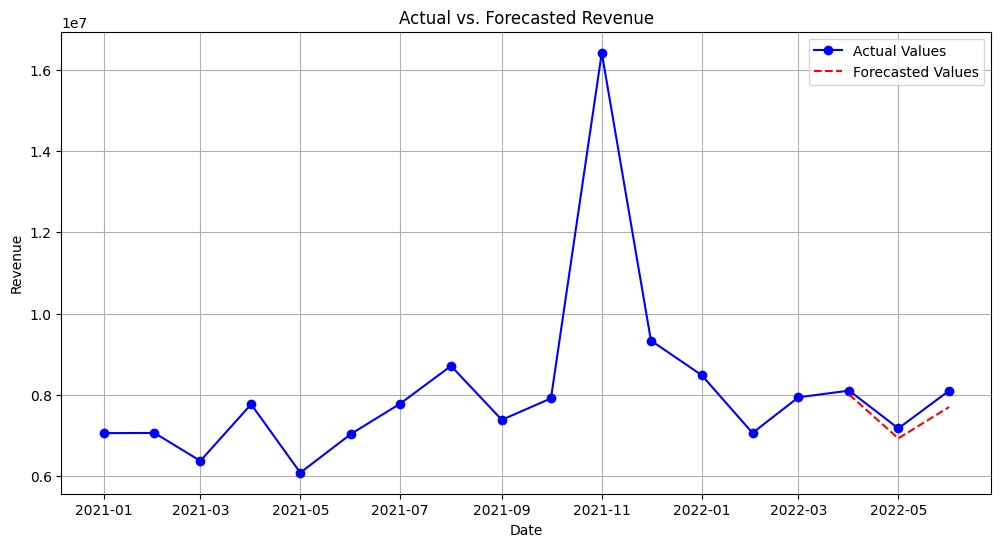

In [208]:
# Forecast for the training set
forecast = best_model.forecast(steps=len(test))
forecast_index = test.index

# Data with actual vs forecast for plotting
results = pd.DataFrame({
    'Date': df['Date'],
    'Actual': pd.concat([train['Monthly Revenue'], test['Monthly Revenue']]),
    'Forecast': pd.concat([pd.Series([np.nan] * len(train), index=train.index), pd.Series(forecast, index=forecast_index)])
})

plt.figure(figsize=(12, 6))
plt.plot(results['Date'], results['Actual'], label='Actual Values', color='blue', marker='o')
plt.plot(results['Date'], results['Forecast'], label='Forecasted Values', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs. Forecasted Revenue')
plt.legend()
plt.grid(True)
plt.show()

The graph shows that the model fits extremely well for the next 3 months: a great sign

In [213]:
# Get the mean squared error for our model
mean_squared_error(test['Monthly Revenue'],forecast)

77238958543.0994

In [212]:
# A percentage point to check for accuracy
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(test['Monthly Revenue'],forecast)

0.031964098453230005

Our model with only 15 months of data shows high level of accuracy. Since it works so well, we can keep this one as the final model

#### Forecasting

In [234]:
# Note historical vs predicted for dashboard
df['Note'] = 'Historical'

forecasted = pd.DataFrame({'Date':pd.date_range(start='2022-07-01', end='2023-06-30', freq='MS'),
              'Monthly Revenue':best_model.forecast(steps=15)[3:],
              'Note': 'Forcasted'})

final = pd.concat([df,forecasted])
final.to_csv('forcasted.csv',index=False)

### YOY Product Analysis

Since we have 18 months of data, we can compare 2021 Jan - June vs 2022 Jan - June in terms of revenue and conversion to see which models have the biggest improvement 

In [324]:
data['Conversion'] = data['Conversion Rate'] * data['Glance Views']
data2021 = data[data['Date']<= '2021-06-01']
data2022 = data[data['Date']>= '2022-01-01']

In [311]:
data2021 = data2021.groupby('Model / Style Number')[['Ordered Revenue','Glance Views','Conversion']].sum().reset_index().rename(
    columns = {'Ordered Revenue':'2021 Revenue'})
data2021['2021 CVR'] = data2021['Conversion']/data2021['Glance Views']
data2021 = data2021.drop(columns = ['Conversion','Glance Views'])

data2022 = data2022.groupby('Model / Style Number')[['Ordered Revenue','Glance Views','Conversion']].sum().reset_index().rename(
    columns = {'Ordered Revenue':'2022 Revenue'})
data2022['2022 CVR'] = data2022['Conversion']/data2022['Glance Views']
data2022 = data2022.drop(columns = ['Conversion','Glance Views'])

In [312]:
yoy = pd.merge(data2021,data2022,on = 'Model / Style Number',how = 'inner')

In [313]:
yoy['Reveneu Change'] = (yoy['2022 Revenue'] - yoy['2021 Revenue'])/yoy['2021 Revenue']
yoy['CVR Change'] = (yoy['2022 CVR'] - yoy['2021 CVR'])/yoy['2021 CVR']

In [315]:
yoy.dropna().to_csv('yoy.csv',index = False)